# Authentification à Google Big Query

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


# Installations et importations

## Installations

### Installation Spark

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!pip install -q pyspark

In [ ]:
!pip install -q findspark

## Importations

### Importation Spark

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
spark

In [ ]:
from pyspark.sql.functions import col, avg, isnan, when, count, col

### Autres importations

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.types import StructType, StructField, StringType, ShortType, DoubleType, IntegerType, ArrayType, FloatType, TimestampType, BooleanType
from google.cloud import bigquery

## Montage du repo drive comme repo actif

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Lecture des données

Les données utilsées peuvent être retrouvées ici :
[Données US Accidents (2016 - 2021)](https://www.kaggle.com/sobhanmoosavi/us-accidents)

In [ ]:
csv_weather_path = "/content/drive/MyDrive/US_Accidents_Dec21_updated.csv"

In [ ]:
dataframe = pd.read_csv(csv_weather_path)

In [ ]:
dataframe_spark = spark.read.options(header=True).csv(csv_weather_path)

# Description du jeu de données

Nous avons ici deux dataframes, un classique panda, et un spark.

Tout d'abord, **décrivons le jeu de données de manière générale**. D'après la page Kaggle où se trouve le jeu de données (lien ci-dessus), ce jeu de données recouvre 49 états des États-Unis, et les données vont de février 2016 à décembre 2021. Ces données sont récoltées d'APIs de différentes origines, comme les caméras de circulation et des capteurs de trafic dans les réseaux routiers par exemple, tout comme des données d'état. Ce dataset est constitué de 2.8 million de données d'accidents.

In [ ]:
nombre_de_donnees = dataframe.shape[0]

In [ ]:
dataframe

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.108910,-83.092860,40.112060,-83.031870,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,2,2016-02-08 05:56:20,2016-02-08 11:56:20,39.865420,-84.062800,39.865010,-84.048730,0.747,At OH-4/OH-235/Exit 41 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-3,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.102660,-84.524680,39.102090,-84.523960,0.055,At I-71/US-50/Exit 1 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Day
3,A-4,2,2016-02-08 06:51:45,2016-02-08 12:51:45,41.062130,-81.537840,41.062170,-81.535470,0.123,At Dart Ave/Exit 21 - Accident.,...,False,False,False,False,False,False,Night,Night,Day,Day
4,A-5,3,2016-02-08 07:53:43,2016-02-08 13:53:43,39.172393,-84.492792,39.170476,-84.501798,0.500,At Mitchell Ave/Exit 6 - Accident.,...,False,False,False,False,False,False,Day,Day,Day,Day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845337,A-2845338,2,2019-08-23 18:03:25,2019-08-23 18:32:01,34.002480,-117.379360,33.998880,-117.370940,0.543,At Market St - Accident.,...,False,False,False,False,False,False,Day,Day,Day,Day
2845338,A-2845339,2,2019-08-23 19:11:30,2019-08-23 19:38:23,32.766960,-117.148060,32.765550,-117.153630,0.338,At Camino Del Rio/Mission Center Rd - Accident.,...,False,False,False,False,False,False,Day,Day,Day,Day
2845339,A-2845340,2,2019-08-23 19:00:21,2019-08-23 19:28:49,33.775450,-117.847790,33.777400,-117.857270,0.561,At Glassell St/Grand Ave - Accident. in the ri...,...,False,False,False,False,False,False,Day,Day,Day,Day
2845340,A-2845341,2,2019-08-23 19:00:21,2019-08-23 19:29:42,33.992460,-118.403020,33.983110,-118.395650,0.772,At CA-90/Marina Fwy/Jefferson Blvd - Accident.,...,False,False,False,False,False,False,Day,Day,Day,Day


In [ ]:
dataframe_spark.show()

+----+--------+-------------------+-------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+-------+--------------+----+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|  ID|Severity|         Start_Time|           End_Time|         Start_Lat|         Start_Lng|           End_Lat|           End_Lng|       Distance(mi)|         Description| Number|        Street|Side|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Directi

Maintenant, **décrivons les colonnes** afin de savoir les interpréter dans le futur et de mieux comprendre la composition du dataset.

Ce dataset est constitué de 47 colonnes :


*   **ID**, l'id de l'opération
*   **Severity**, la sévérité de l'accident, entier compris entre 1 et 4. Plus précisément, 1 représente un impacte moindre sur le traffic (faible bouchons) et 4 un impact significatif sur le traffic
*   **Start_Time**, représente l'heure de départ de l'accident (heure locale)
*   **End_Time**, représente l'heure de fin de l'accident (heure locale), c'est à dire l'heure où l'accident n'a plus d'impact sur le traffic
*   **Start_Lat**, la lattitude de départ de l'accident (coordonnées GPS)
*   **Start_Lng**, la longitude de départ de l'accident (coordonnées GPS)
*   **End_Lat**, la lattitude de fin de l'accident (coordonnées GPS)
*   **End_Lng**, la longitude de fin de l'accident (coordonnées GPS)
*   **Distance(mi)**, la distance en Miles qui correspond à la longueur de la route affectée par l'accident
*   **Description**, une description faite par un humain
*   **Number**, le numéro de la rue
*   **Street**, le nom de la rue
*   **Side**, côté relatif (droite/gauche) de la rue
*   **City**, la ville
*   **County**, le compté
*   **State**, l'état
*   **Zipcode**, le code postal
*   **Country**, le pays
*   **Timezone**, la timezone du lieu de l'accident
*   **Airport_Code**, le code de l'aéroport le plus prêt du lieu de l'accident où il y a une station météo
*   **Weather_Timestamp**, l'heure de l'observation météo associée
*   **Temperature(F)**, la temperature en farenheit
*   **Wind_Chill(F)**, la température du vent en farenheit
*   **Humidity(%)**, le pourcentage d'humidité
*   **Pressure(in)**, la pression de l'air en pouces
*   **Visibility(mi)**, la visibilité en miles
*   **Wind_Direction**, la direction du vent
*   **Wind_Speed(mph)**, la vitesse du vent en miles par heure
*   **Precipitation(in)**, la précipitation en pouces
*   **Weather_Condition**, les conditions météos
*   **Amenity**, présence d'un équipement à proximité
*   **Bump**, présence d'un dos d'âne à proximité ou non
*   **Crossing**, présence d'un passage à niveau à proximité
*   **Give_Way**, présence d'un Cédez le passage à proximité
*   **Junction**, présence d'un carrefour à proximité
*   **No_Exit**, présence d'une voie sans issue à proximité
*   **Railway**, présence d'un chemin de fer à proximité
*   **Roundabout**, présence d'un rond point à proximité
*   **Station**, présence d'une station à proximité
*   **Stop**, présence d'un stop à proximité
*   **Traffic_Calming**, présence d'une ralentissement de circulation à proximité
*   **Traffic_Signal**, présence d'un signal de traffic à proximité
*   **Turning_Loop**, présence d'une boucle de retournement (sortie d'autoroute par exemple) à proximité
*   **Sunrise_Sunset**, présence du jour (lever ou coucher du soleil)
*   **Civil_Twilight**, période de la journée (jour ou nuit) basé sur le crépuscule civil
*   **Nautical_Twilight**, période de la journée (jour ou nuit) basé sur le crépuscule nautique
*   **Astronomical_Twilight**, période de la journée (jour ou nuit) basé sur le crépuscule astronomique


Pour un peu plus d'explications sur les différences de [crépuscule](https://www.futura-sciences.com/sciences/definitions/univers-crepuscule-5210/). Pour résumer, ils correspondent à une inclinaison différente du soleil au dessus de l'horizon.

In [ ]:
colonnes = np.array(dataframe.columns.tolist())
colonnes

array(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Number', 'Street', 'Side', 'City', 'County', 'State', 'Zipcode',
       'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump',
       'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
       'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset',
       'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'],
      dtype='<U21')

In [ ]:
colonnes_spark = np.array(dataframe_spark.columns)
colonnes_spark

array(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Number', 'Street', 'Side', 'City', 'County', 'State', 'Zipcode',
       'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump',
       'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
       'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset',
       'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'],
      dtype='<U21')

# Pré-traitement des données

## Dataframe Pandas

### Typage des données

On regarde le type de données juste après l'importation

In [ ]:
dataframe.dtypes

ID                        object
Severity                   int64
Start_Time                object
End_Time                  object
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description               object
Number                   float64
Street                    object
Side                      object
City                      object
County                    object
State                     object
Zipcode                   object
Country                   object
Timezone                  object
Airport_Code              object
Weather_Timestamp         object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             float64
Visibility(mi)           float64
Wind_Direction            object
Wind_Speed(mph)          float64
Precipitation(in)        float64
Weather_Condition         object
Amenity   

On remarque que les types des données, qui sont déterminés par Pandas automatiquement, ne sont pas tous bien définis, notamment les dates. Pour ce qui est des strings, on voit qu'elles sont toutes marquées comme object. On va donc instancier les bons types aux colonnes, c'est à dire convertir les `Start_Time` et `End_Time` en timestamp et convertir tous les autres object en String.

In [ ]:
dataframe["Start_Time"] = pd.to_datetime(dataframe["Start_Time"])
dataframe["End_Time"] = pd.to_datetime(dataframe["End_Time"])

In [ ]:
dataframe = dataframe.astype({'ID':'string', "Description" : "string", "Street" : "string", "Side" : "string", "City" : "string", "County" : "string"})
dataframe = dataframe.astype({'State':'string', "Zipcode" : "string", "Country" : "string", "Timezone" : "string", "Airport_Code" : "string"})
dataframe = dataframe.astype({'Weather_Timestamp':'string', "Wind_Direction" : "string", "Weather_Condition" : "string", "Sunrise_Sunset" : "string"})
dataframe = dataframe.astype({'Civil_Twilight':'string', "Nautical_Twilight" : "string", "Astronomical_Twilight" : "string"})

In [ ]:
dataframe.dtypes

ID                               string
Severity                          int64
Start_Time               datetime64[ns]
End_Time                 datetime64[ns]
Start_Lat                       float64
Start_Lng                       float64
End_Lat                         float64
End_Lng                         float64
Distance(mi)                    float64
Description                      string
Number                          float64
Street                           string
Side                             string
City                             string
County                           string
State                            string
Zipcode                          string
Country                          string
Timezone                         string
Airport_Code                     string
Weather_Timestamp                string
Temperature(F)                  float64
Wind_Chill(F)                   float64
Humidity(%)                     float64
Pressure(in)                    float64


### Modification des unités

On convertit les miles en kilomètres pour une meilleure représentation des données. On [remarque](https://www.rapidtables.com/convert/length/mile-to-km.html) que 1 mile = 1.609344 km.

In [ ]:
print("Première distance du DF avant conversion : ", dataframe["Distance(mi)"][0], " miles")
dataframe["Distance(mi)"] = dataframe["Distance(mi)"].apply(lambda x: x * 1.609344)
print("Première distance du DF après conversion : ", dataframe["Distance(mi)"][0], " kilomètres")

dataframe["Visibility(mi)"] = dataframe["Visibility(mi)"].apply(lambda x: x * 1.609344)
dataframe["Wind_Speed(mph)"] = dataframe["Wind_Speed(mph)"].apply(lambda x: x * 1.609344)

Première distance du DF avant conversion :  3.23  miles
Première distance du DF après conversion :  5.19818112  kilomètres


On fait de même pour la température et pour la température du vent, que l'on converti de farenheit à celsius. On [retrouve](https://www.meteo.be/fr/infos/faq/mesures-et-unites-de-mesure/comment-convertir-les-degres-fahrenheit-en-degres-celsius-ou-en-degres-kelvin) cette formule : `°C = (°F - 32) / 1,8`

In [ ]:
print("Première température du DF avant conversion : ", dataframe["Temperature(F)"][0], "°F")
dataframe["Temperature(F)"] = dataframe["Temperature(F)"].apply(lambda x: (x - 32) / 1.8)
print("Première température du DF après conversion : ", dataframe["Temperature(F)"][0], "°C")

dataframe["Wind_Chill(F)"] = dataframe["Wind_Chill(F)"].apply(lambda x: (x - 32) / 1.8)

Première température du DF avant conversion :  42.1 °F
Première température du DF après conversion :  5.611111111111112 °C


Pour les précipitations, on convertir les pouces en millimètres, unité classique pour mesurer cet indicateur. On [voit](https://www.rapidtables.com/convert/length/inch-to-mm.html) que 1 pouce = 25.4 mm.

In [ ]:
print("Onzième précipitation du DF avant conversion : ", dataframe["Precipitation(in)"][10], "in")
dataframe["Precipitation(in)"] = dataframe["Precipitation(in)"].apply(lambda x: x * 24.5)
print("Onzième précipitation du DF après conversion : ", dataframe["Precipitation(in)"][10], "mm")

Onzième précipitation du DF avant conversion :  0.03 in
Onzième précipitation du DF après conversion :  0.735 mm


### On renomme les colonnes concernées

In [ ]:
dataframe = dataframe.rename(columns = {'Distance(mi)': 'Distance(km)', 'Temperature(F)': 'Temperature(C)', 'Wind_Chill(F)': 'Wind_Chill(C)'})
dataframe = dataframe.rename(columns = {'Visibility(mi)' : 'Visibility(km)', 'Wind_Speed(mph)' : 'Wind_Speed(kmh)', 'Precipitation(in)' : 'Precipitation(mm)'})

In [ ]:
dataframe.columns

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(km)', 'Description', 'Number', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(C)', 'Wind_Chill(C)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(km)', 'Wind_Direction',
       'Wind_Speed(kmh)', 'Precipitation(mm)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

## Dataframe Spark

### Typage des données

In [ ]:
dataframe_spark.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Severity: string (nullable = true)
 |-- Start_Time: string (nullable = true)
 |-- End_Time: string (nullable = true)
 |-- Start_Lat: string (nullable = true)
 |-- Start_Lng: string (nullable = true)
 |-- End_Lat: string (nullable = true)
 |-- End_Lng: string (nullable = true)
 |-- Distance(mi): string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Number: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- Side: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: string (nullable = true)
 |-- Temperature(F): string (nullable = true)
 |-- Wind_Chill(F): string (nullable = true)
 |-- Humidity(%): string (nullable = true)
 |-- Pressure(in): strin

On remarque aussi que les types définis par spark sont, eux-aussi, mal déterminés, et sont tous définis à string

In [ ]:
 schema_spark = StructType([
    StructField("ID", StringType(), False),
    StructField("Severity", IntegerType(), False),
    StructField("Start_Time", TimestampType(), False),
    StructField("End_Time", TimestampType(), False),
    StructField("Start_Lat", DoubleType(), False),
    StructField("Start_Lng", DoubleType(), False),
    StructField("End_Lat", DoubleType(), False),
    StructField("End_Lng", DoubleType(), False),
    StructField("Distance(mi)", DoubleType(), False),
    StructField("Description", StringType(), False),
    StructField("Number", DoubleType(), False),
    StructField("Street", StringType(), False),
    StructField("Side", StringType(), False),
    StructField("City", StringType(), False),
    StructField("County", StringType(), False),
    StructField("State", StringType(), False),
    StructField("Zipcode", StringType(), False),
    StructField("Country", StringType(), False),
    StructField("Timezone", StringType(), False),
    StructField("Airport_Code", StringType(), False),
    StructField("Weather_Timestamp", StringType(), False),
    StructField("Temperature(F)", DoubleType(), False),
    StructField("Wind_Chill(F)", DoubleType(), False),
    StructField("Humidity(%)", DoubleType(), False),
    StructField("Pressure(in)", DoubleType(), False),
    StructField("Visibility(mi)", DoubleType(), False),
    StructField("Wind_Direction", StringType(), False),
    StructField("Wind_Speed(mph)", DoubleType(), False),
    StructField("Precipitation(in)", DoubleType(), False),
    StructField("Weather_Condition", StringType(), False),
    StructField("Amenity", BooleanType(), False),
    StructField("Bump", BooleanType(), False),
    StructField("Crossing", BooleanType(), False),
    StructField("Give_Way", BooleanType(), False),
    StructField("Junction", BooleanType(), False),
    StructField("No_Exit", BooleanType(), False),
    StructField("Railway", BooleanType(), False),
    StructField("Roundabout", BooleanType(), False),
    StructField("Station", BooleanType(), False),
    StructField("Stop", BooleanType(), False),
    StructField("Traffic_Calming", BooleanType(), False),
    StructField("Traffic_Signal", BooleanType(), False),
    StructField("Turning_Loop", BooleanType(), False),
    StructField("Sunrise_Sunset", StringType(), False),
    StructField("Civil_Twilight", StringType(), False),
    StructField("Nautical_Twilight", StringType(), False),
    StructField("Astronomical_Twilight", StringType(), False)
])

In [ ]:
dataframe_spark = spark.read.options(header=True).schema(schema_spark).csv([csv_weather_path])            
dataframe_spark.show()

+----+--------+-------------------+-------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+-------+--------------+----+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|  ID|Severity|         Start_Time|           End_Time|         Start_Lat|         Start_Lng|           End_Lat|           End_Lng|       Distance(mi)|         Description| Number|        Street|Side|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Directi

In [ ]:
dataframe_spark.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Number: double (nullable = true)
 |-- Street: string (nullable = true)
 |-- Side: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: string (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in)

### Modification des unités

Miles -> kilomètres

In [ ]:
print("Avant conversion (miles) : ")
dataframe_spark.show()

dataframe_spark = dataframe_spark.withColumn("Distance(mi)", col("Distance(mi)") * 1.609344)
dataframe_spark = dataframe_spark.withColumn("Visibility(mi)", col("Visibility(mi)") * 1.609344)
dataframe_spark = dataframe_spark.withColumn("Wind_Speed(mph)", col("Wind_Speed(mph)") * 1.609344)

print("Après conversion (kilomètres) : ")
dataframe_spark.show()

Avant conversion (miles) : 
+----+--------+-------------------+-------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+-------+--------------+----+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|  ID|Severity|         Start_Time|           End_Time|         Start_Lat|         Start_Lng|           End_Lat|           End_Lng|       Distance(mi)|         Description| Number|        Street|Side|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)

Farenheit -> Celsius

In [ ]:
print("Avant conversion (farenheit) : ")
dataframe_spark.show()

dataframe_spark = dataframe_spark.withColumn("Temperature(F)", (col("Temperature(F)") - 32) / 1.8)
dataframe_spark = dataframe_spark.withColumn("Wind_Chill(F)", (col("Wind_Chill(F)") - 32) / 1.8)

print("Après conversion (celsius) : ")
dataframe_spark.show()

Avant conversion (farenheit) : 
+----+--------+-------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+-------+--------------+----+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+------------------+--------------+------------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|  ID|Severity|         Start_Time|           End_Time|         Start_Lat|         Start_Lng|           End_Lat|           End_Lng|        Distance(mi)|         Description| Number|        Street|Side|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)

Inches -> mm

In [ ]:
print("Avant conversion (inches) : ")
dataframe_spark.show()

dataframe_spark = dataframe_spark.withColumn("Precipitation(in)", col("Precipitation(in)") * 24.5)

print("Après conversion (mm) : ")
dataframe_spark.show()

Avant conversion (inches) : 
+----+--------+-------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+-------+--------------+----+------------+----------+-----+----------+-------+----------+------------+-------------------+------------------+--------------------+-----------+------------+------------------+--------------+------------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|  ID|Severity|         Start_Time|           End_Time|         Start_Lat|         Start_Lng|           End_Lat|           End_Lng|        Distance(mi)|         Description| Number|        Street|Side|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|    Temperature(F)|       Wind_C

### On renomme les colonnes concernées

In [ ]:
dataframe_spark = dataframe_spark.withColumnRenamed('Distance(mi)', 'Distance(km)').withColumnRenamed('Temperature(F)','Temperature(C)').withColumnRenamed('Wind_Chill(F)','Wind_Chill(C)').withColumnRenamed('Visibility(mi)','Visibility(km)').withColumnRenamed('Wind_Speed(mph)','Wind_Speed(kmh)').withColumnRenamed('Precipitation(in)','Precipitation(mm)')

In [ ]:
dataframe_spark.columns

['ID',
 'Severity',
 'Start_Time',
 'End_Time',
 'Start_Lat',
 'Start_Lng',
 'End_Lat',
 'End_Lng',
 'Distance(km)',
 'Description',
 'Number',
 'Street',
 'Side',
 'City',
 'County',
 'State',
 'Zipcode',
 'Country',
 'Timezone',
 'Airport_Code',
 'Weather_Timestamp',
 'Temperature(C)',
 'Wind_Chill(C)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(km)',
 'Wind_Direction',
 'Wind_Speed(kmh)',
 'Precipitation(mm)',
 'Weather_Condition',
 'Amenity',
 'Bump',
 'Crossing',
 'Give_Way',
 'Junction',
 'No_Exit',
 'Railway',
 'Roundabout',
 'Station',
 'Stop',
 'Traffic_Calming',
 'Traffic_Signal',
 'Turning_Loop',
 'Sunrise_Sunset',
 'Civil_Twilight',
 'Nautical_Twilight',
 'Astronomical_Twilight']

# Interprétation des données avec Pandas

Dans ce chapitre, nous ferons une première analyse des données à l'aide de la librairie Pandas, et du dataframe récupéré grâce à celle-ci. L'outil étant moins puissant que les deux suivants que nous utiliserons par la suite, cette analyse sera moins approfondie que les deux suivantes, et il sera clairement indiqué lorque nous avons pris des raccourcis, ou émis des suppositions, afin de ne pas alourdir inutilement le calcul. Ainsi, ce paragraphe s'inscrit d'avantage comme une première approche, et une première visualisation des données, afin de mieux connaître le jeu de données.

## Représentation basique des données

In [ ]:
nombre_de_donnees = dataframe.shape[0]
print("Il y a ", nombre_de_donnees, " donnees dans le dataframe")

Il y a  2845342  donnees dans le dataframe


In [ ]:
dataframe.describe()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(km),Number,Temperature(C),Wind_Chill(C),Humidity(%),Pressure(in),Visibility(km),Wind_Speed(kmh),Precipitation(mm)
count,2.845342e+06,2.845342e+06,2.845342e+06,2.845342e+06,2.845342e+06,2.845342e+06,1.101431e+06,2.776068e+06,2.375699e+06,2.772250e+06,2.786142e+06,2.774796e+06,2.687398e+06,2.295884e+06
mean,2.137572e+00,3.624520e+01,-9.711463e+01,3.624532e+01,-9.711439e+01,1.130850e+00,8.089408e+03,1.655198e+01,1.536568e+01,6.436545e+01,2.947234e+01,1.464405e+01,1.190117e+01,1.719150e-01
std,4.787216e-01,5.363797e+00,1.831782e+01,5.363873e+00,1.831763e+01,2.511157e+00,1.836009e+04,1.034591e+01,1.175609e+01,2.287457e+01,1.045286e+00,4.373466e+00,8.895575e+00,2.290464e+00
min,1.000000e+00,2.456603e+01,-1.245481e+02,2.456601e+01,-1.245457e+02,0.000000e+00,0.000000e+00,-6.722222e+01,-6.722222e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,3.344517e+01,-1.180331e+02,3.344628e+01,-1.180333e+02,8.368589e-02,1.270000e+03,1.000000e+01,7.777778e+00,4.800000e+01,2.931000e+01,1.609344e+01,5.632704e+00,0.000000e+00
50%,2.000000e+00,3.609861e+01,-9.241808e+01,3.609799e+01,-9.241772e+01,3.926799e-01,4.007000e+03,1.777778e+01,1.722222e+01,6.700000e+01,2.982000e+01,1.609344e+01,1.126541e+01,0.000000e+00
75%,2.000000e+00,4.016024e+01,-8.037243e+01,4.016105e+01,-8.037338e+01,1.229539e+00,9.567000e+03,2.444444e+01,2.444444e+01,8.300000e+01,3.001000e+01,1.609344e+01,1.609344e+01,0.000000e+00
max,4.000000e+00,4.900058e+01,-6.711317e+01,4.907500e+01,-6.710924e+01,2.497477e+02,9.999997e+06,9.111111e+01,9.111111e+01,1.000000e+02,5.890000e+01,2.253082e+02,1.749357e+03,5.880000e+02


Certaines données ne sont pas forcément utiles, mais nous permet d'avoir une vue globale de certaines données. On peut par exemple évoquer le fait qu'étant donné les températures maximales et minimales (et ayant vérifié les données et la conversion), il est possible que les données de températures entrées ne sont pas tout le temps cohérentes.

<BarContainer object of 47 artists>

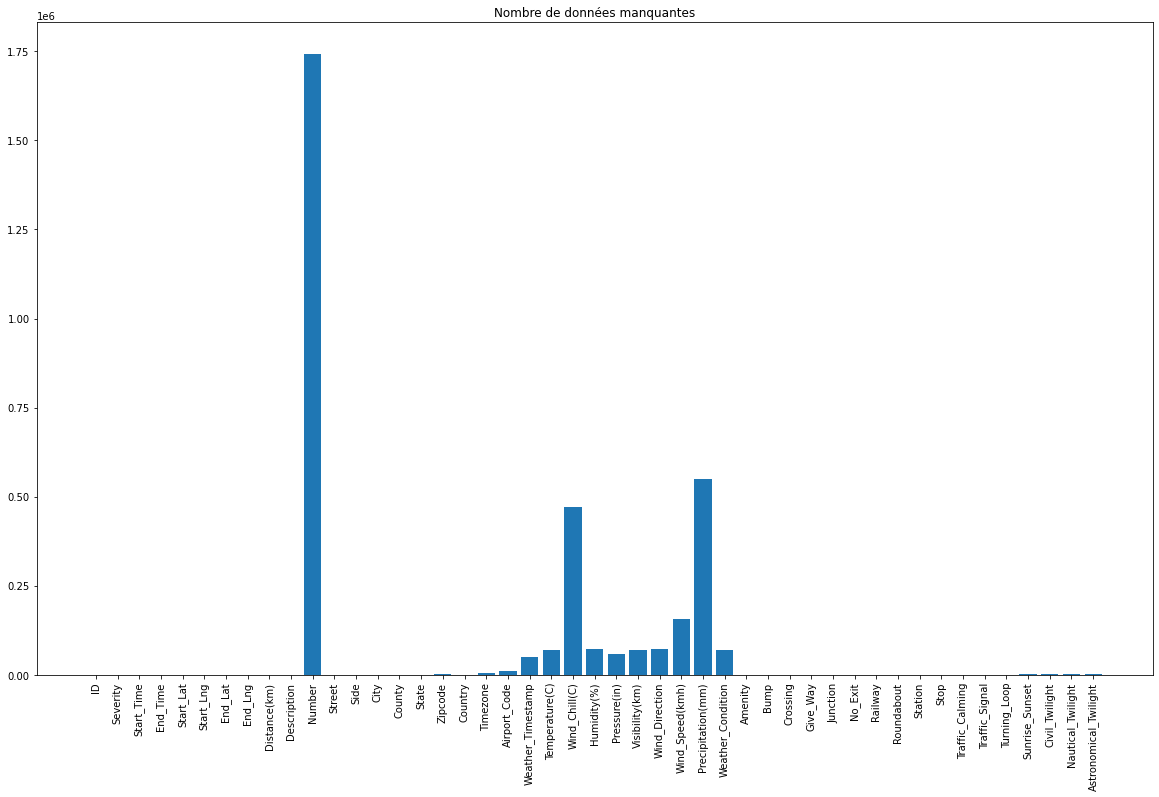

In [ ]:
colonnes = dataframe.columns
valeurs_manquantes = np.array(dataframe.isnull().sum(axis=0).tolist())
fig,ax = plt.subplots(figsize=(20,12))
plt.xticks(rotation = 'vertical')
plt.title("Nombre de données manquantes")
plt.bar(colonnes, valeurs_manquantes)

Il est très important de reporter les données manquantes, afin de ne pas faire de mauvaise interprétation des résultats. En effet, si on a, par exemple, 80% des lignes de sévérité 1, et qu'il n'y a que 80% des sévérités enseignées, cela veut dire que 100% des données renseignées sont des accidents de sévérité 1.

Ici, on voit que de nombreux indicateurs n'ont pas de donnée manquante, ce qui est très intéressant.

In [ ]:
valeurs_manquantes_non_nulles = valeurs_manquantes[valeurs_manquantes != 0]
indices_valeurs_manquantes_non_nulles = colonnes[valeurs_manquantes != 0]
print("Valeurs manquantes : ", valeurs_manquantes_non_nulles)
print("Indices associés : ", indices_valeurs_manquantes_non_nulles)

Valeurs manquantes :  [1743911       2     137    1319    3659    9549   50736   69274  469643
   73092   59200   70546   73775  157944  549458   70636    2867    2867
    2867    2867]
Indices associés :  Index(['Number', 'Street', 'City', 'Zipcode', 'Timezone', 'Airport_Code',
       'Weather_Timestamp', 'Temperature(C)', 'Wind_Chill(C)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(km)', 'Wind_Direction', 'Wind_Speed(kmh)',
       'Precipitation(mm)', 'Weather_Condition', 'Sunrise_Sunset',
       'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'],
      dtype='object')


<BarContainer object of 20 artists>

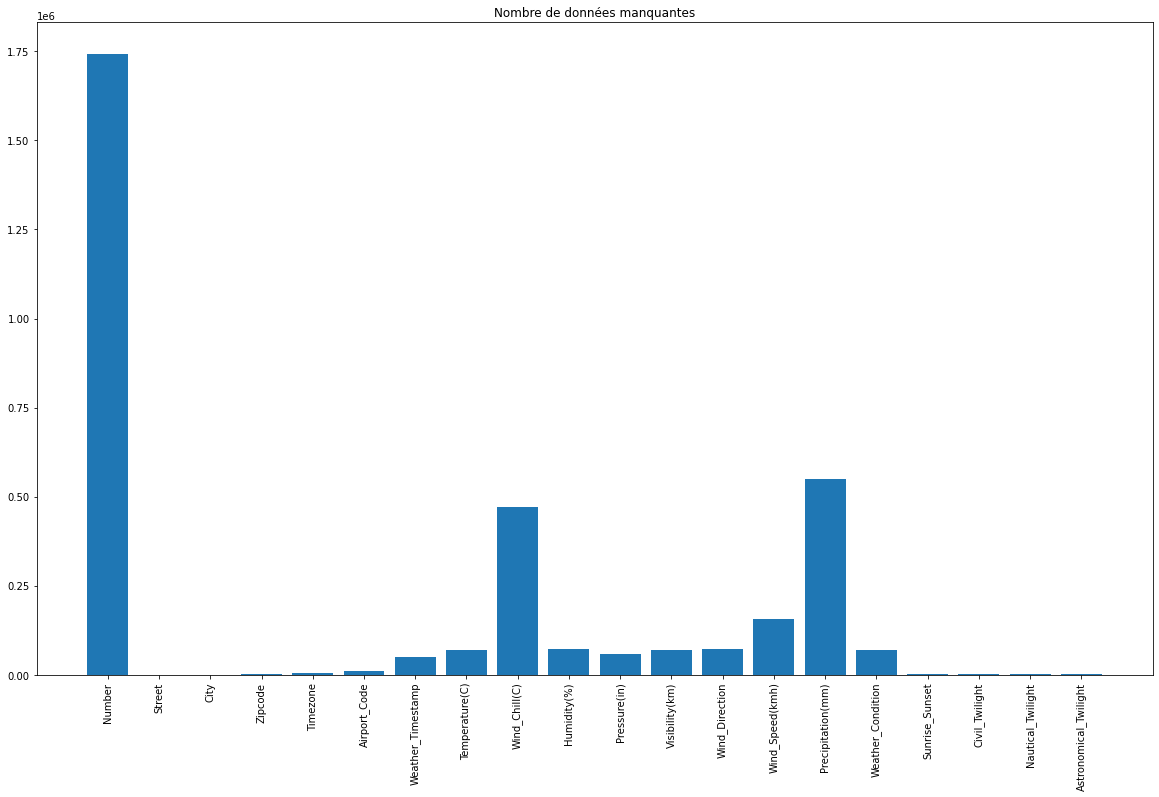

In [ ]:
fig,ax = plt.subplots(figsize=(20,12))
plt.xticks(rotation = 'vertical')
plt.title("Nombre de données manquantes")
plt.bar(indices_valeurs_manquantes_non_nulles, valeurs_manquantes_non_nulles)

In [ ]:
print(len(valeurs_manquantes_non_nulles), " indices avec des valeurs manquantes.")

20  indices avec des valeurs manquantes.


On voit qu'il y a 20 indices avec des valeurs manquantes, donc moins de la moitié des indices totaux.

Il faut maintenant regarder les indices où il y a le plus de données manquantes, et voir si cela aura un impact important sur notre travail.

L'indice "Number", c'est à dire le nombre de la rue, ne sera pas important ici, car nous ne chercherons pas à faire des interprétations par rapport au numéro de la rue.

L'indice "Precipitation" est lui important dans notre étude, car les précipitations peuvent avoir un impact sur les accidents. Il faudra donc mettre en relief les données renseignées par rapport au nombre de données renseignées, et non par rapport au nombre de données total.

L'indice "Wind_Chill" n'est pas utile pour notre analyse.

Les autres indices ont un nombre de données manquantes faible et donc très peu significatives sur le nombre de données totales. Cependant, nous calculerons deux indices : le poucentage par rapport au nombre total de données, et le pourcentage par rapport au nombre de données renseignées.

## Répartition de la sévérité

In [ ]:
minimum_severite = dataframe["Severity"].min()
maximum_severite = dataframe["Severity"].max()
print("Les niveaux de sévérité de l'accident vont de ", minimum_severite, " à ", maximum_severite)

Les niveaux de sévérité de l'accident vont de  1  à  4


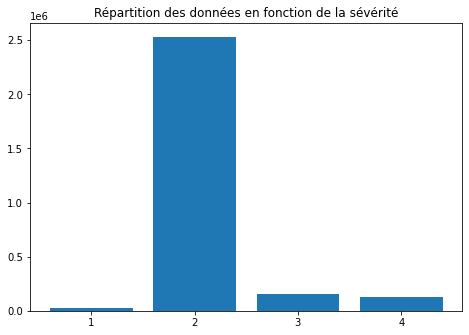

In [ ]:
compteur_valeurs_severite = dataframe["Severity"].value_counts()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
intitules = []
donnees = []
for i in range(minimum_severite, maximum_severite + 1):
  intitules.append(str(i))
  donnees.append(compteur_valeurs_severite[i])
  ax.set_title('Répartition des données en fonction de la sévérité')
ax.bar(intitules,donnees)
plt.show()

On remarque que les données ne sont vraiment pas réparties uniformément, et il y a beaucoup plus de données de sévérité 2, quand les autres sévérités sont globalement dans le même ordre de grandeur.

## Accidents par état

<BarContainer object of 49 artists>

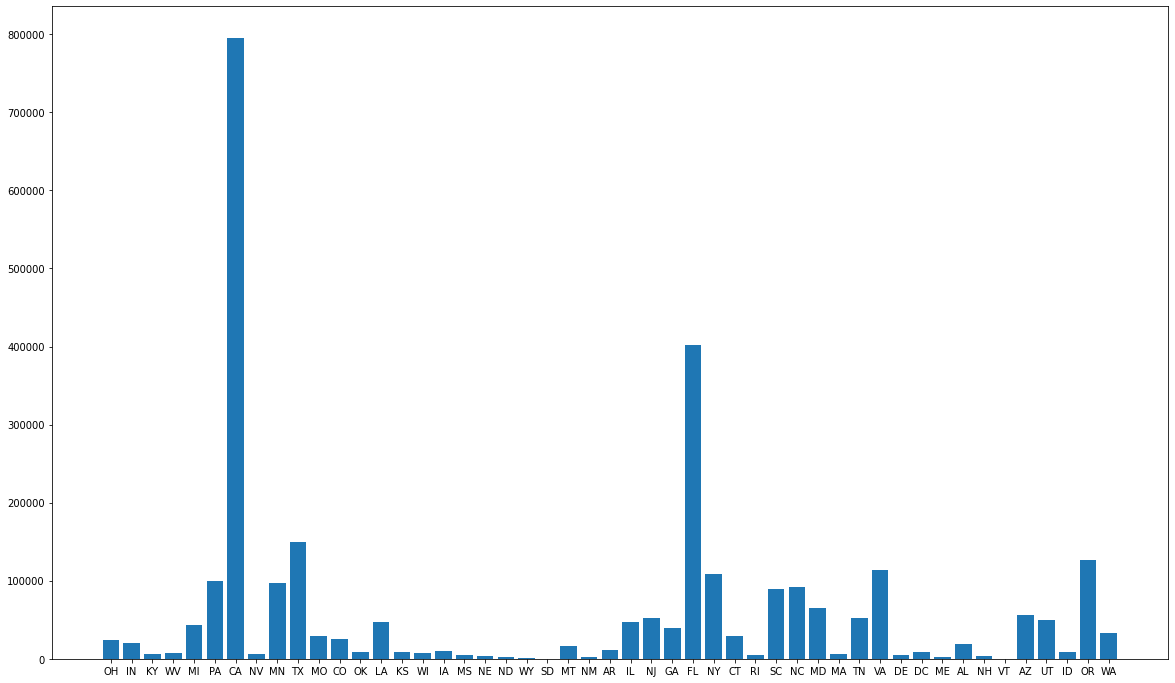

In [ ]:
etats = dataframe["State"].unique()
nombre_accidents_par_etat = []
for etat in etats:
    nombre_accidents_par_etat.append(dataframe[dataframe['State']== etat].count()['State'])
fig,ax = plt.subplots(figsize=(20,12))
plt.bar(etats, nombre_accidents_par_etat)

On remarque que la grande majorité des accidents ont lieu en Californie. Le deuxième plus grand nombre d'accident est la Floride, mais avec près de 2 fois moins d'accidents. Les données suivantes sont très éloignées, avec plus de 3 fois moins d'accidents que la Floride. On remarque [ici](https://fr.countryeconomy.com/demographie/population/etats-unis-etats) que la Californie est l'Etat des USA avec le plus grand nombre d'habitants, avec environ 40M et 10M de plus que le second état, le Texas, ce qui peut expliquer ce nombre d'accidents beaucoup plus élevé.
Le second état, le Texas, est le troisième état avec le plus d'accidents reportés, avec 3 fois moins que la Floride, alors que le Texas a 8M d'habitants de plus que la Floride.

## Détermination du minimum et du maximum de la distance de l'accident

In [ ]:
minimum_distance = dataframe["Distance(km)"].min()
maximum_distance = dataframe["Distance(km)"].max()
print("Les distances de l'accident vont de ", minimum_distance, " à ", maximum_distance, "kilomètres")

Les distances de l'accident vont de  0.0  à  249.74765798400003 kilomètres


In [ ]:
def repartition_donnees_distance(data, min, max):
  nombre_partitions = 10
  facteur_additif = round((min + max) / nombre_partitions, 2)
  pas_fini = True
  borne_min = min
  borne_max = borne_min
  legende = []
  valeurs = []
  while pas_fini:
    borne_max += facteur_additif
    dataframe_bis = dataframe[dataframe['Distance(km)'] < borne_max]
    dataframe_bis = dataframe_bis[dataframe_bis['Distance(km)'] >= borne_min]
    valeurs.append(dataframe_bis.count()[0])
    legende.append(str(borne_min) + "<=Dist.<" + str(borne_max))
    borne_min += facteur_additif
    pas_fini = borne_max <= max
  fig,ax = plt.subplots(figsize=(20,12))
  plt.xticks(rotation = 'vertical')
  plt.title("Nombre de données par distance")
  plt.bar(legende, valeurs)

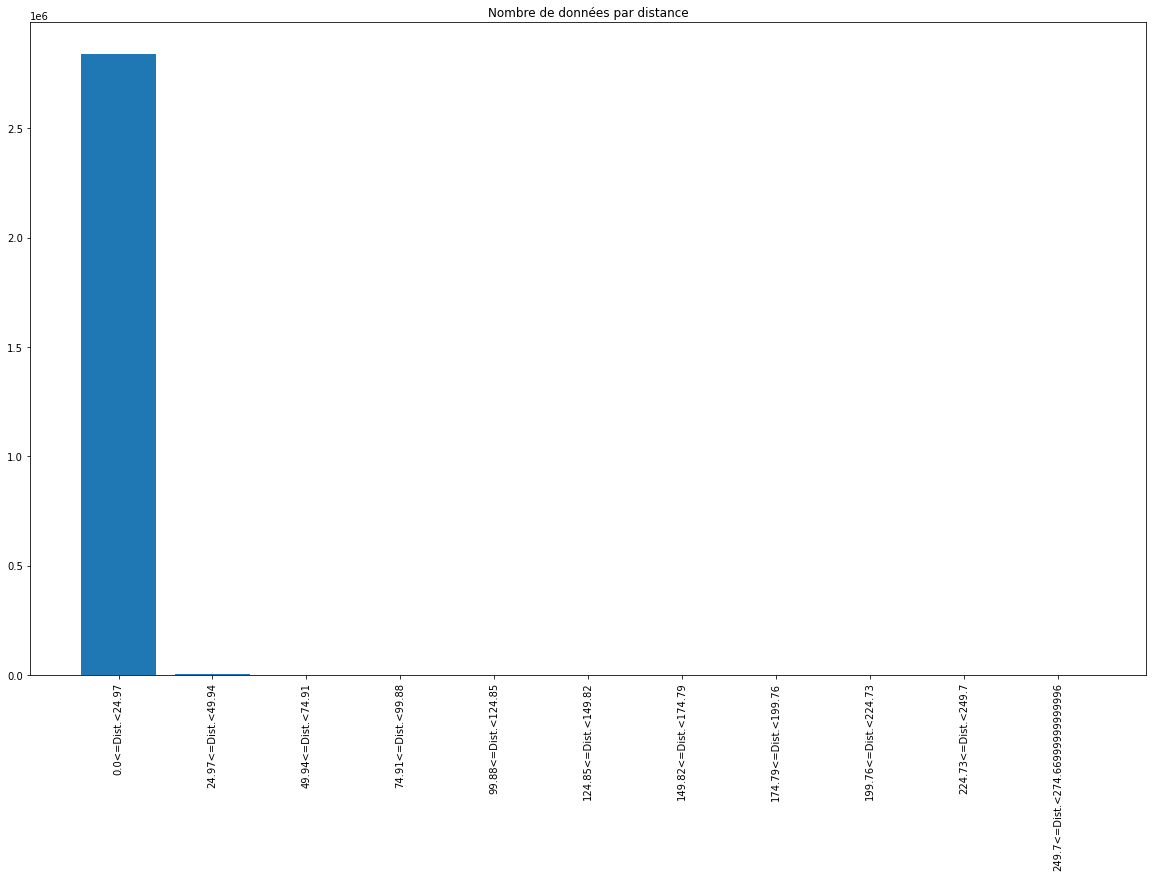

In [ ]:
repartition_donnees_distance(np.array(dataframe["Distance(km)"]), float(minimum_distance), float(maximum_distance))

On voit que, pour 10 partitions, les données de distance ne sont pas du tout reparties équitablement. 

In [ ]:
valeurs_inferieures_a_2497 = dataframe[dataframe['Distance(km)'] < 24.97].count()[0]
print(valeurs_inferieures_a_2497, " accidents qui ont impacté moins de 24.92 km (première borne du graphe pour 10 partitions)")
valeurs_superieures_a_2497 = dataframe[dataframe['Distance(km)'] >= 24.97].count()[0]
print(valeurs_superieures_a_2497, " accidents qui ont impacté au moins 24.92 km (première borne du graphe pour 10 partitions)")

2842516  accidents qui ont impacté moins de 24.92 km (première borne du graphe pour 10 partitions)
2826  accidents qui ont impacté au moins 24.92 km (première borne du graphe pour 10 partitions)


<BarContainer object of 2 artists>

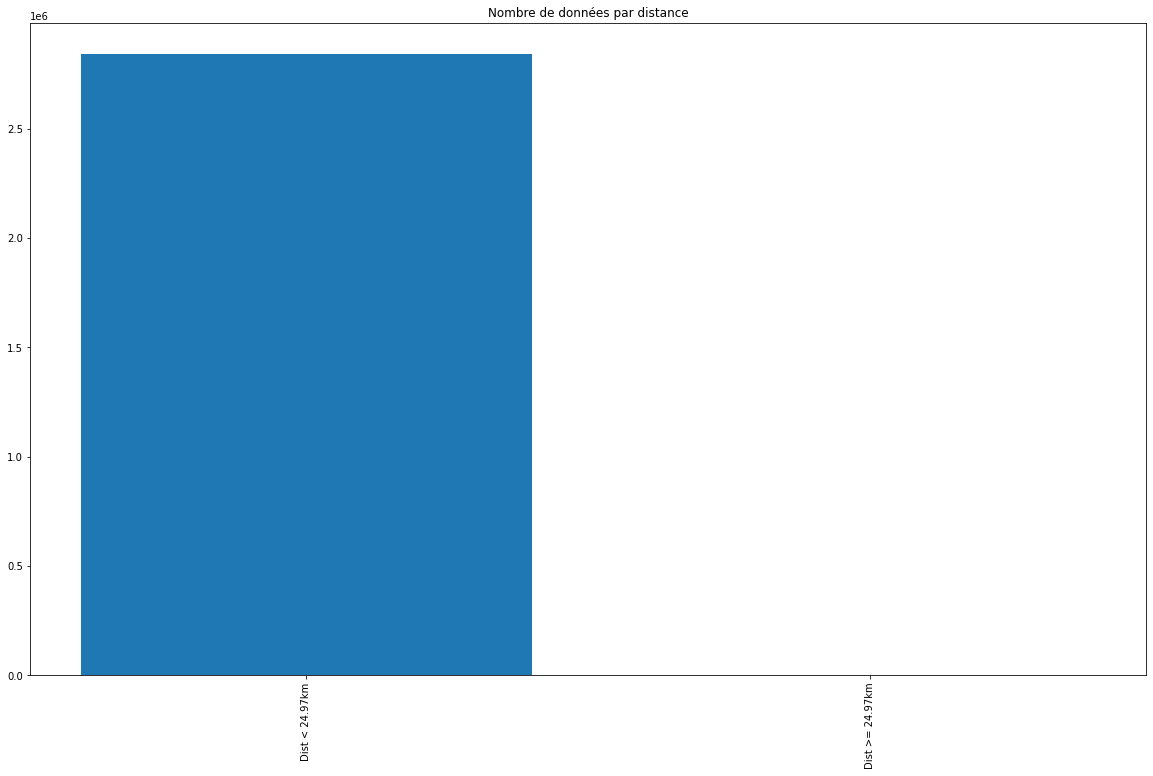

In [ ]:
fig,ax = plt.subplots(figsize=(20,12))
plt.xticks(rotation = 'vertical')
plt.title("Nombre de données par distance")
plt.bar(["Dist < 24.97km", "Dist >= 24.97km"], [valeurs_inferieures_a_2497, valeurs_superieures_a_2497])

On voit que 2.8M de données ont impacté moins de 24.92km, quand 2826 seulement ont impacté entre 24.92 et 250 km.

In [ ]:
valeurs_inferieures_a_1 = dataframe[dataframe['Distance(km)'] < 1].count()[0]
print(valeurs_inferieures_a_1, " accidents qui ont impacté moins de 1 km")
valeurs_superieures_a_1 = dataframe[dataframe['Distance(km)'] >= 1].count()[0]
print(valeurs_superieures_a_1, " accidents qui ont impacté au moins 1 km")

2003262  accidents qui ont impacté moins de 1 km
842080  accidents qui ont impacté au moins 1 km


<BarContainer object of 2 artists>

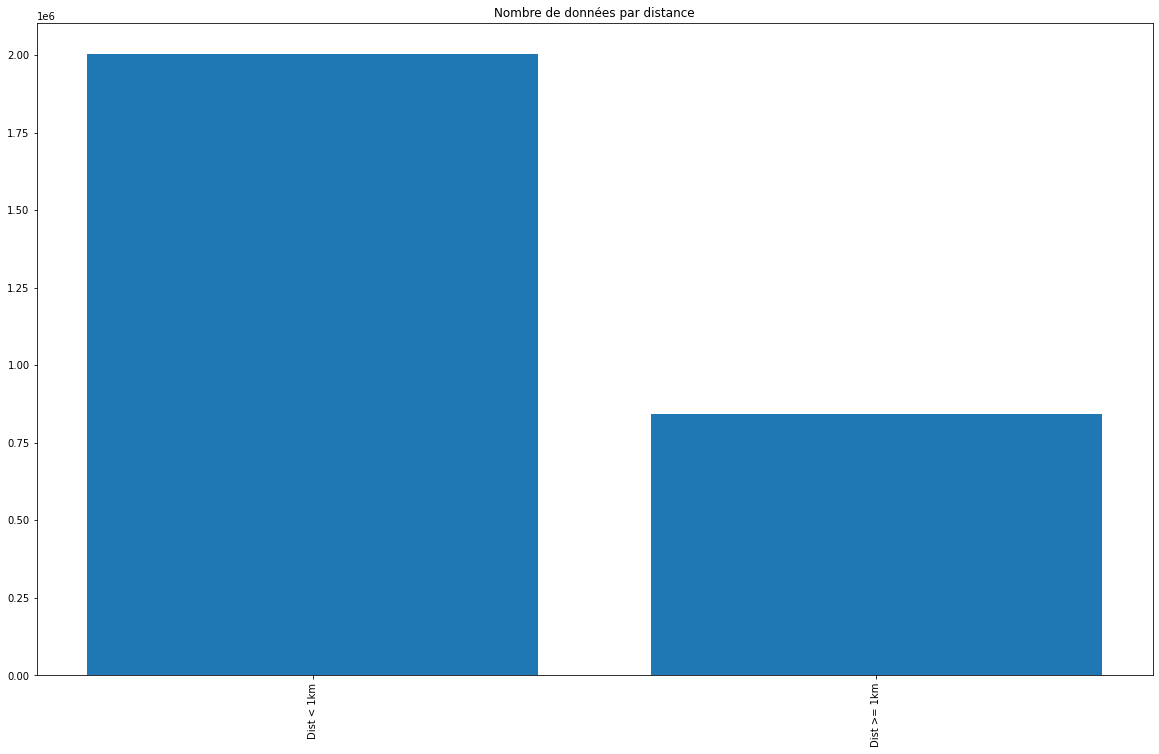

In [ ]:
fig,ax = plt.subplots(figsize=(20,12))
plt.xticks(rotation = 'vertical')
plt.title("Nombre de données par distance")
plt.bar(["Dist < 1km", "Dist >= 1km"], [valeurs_inferieures_a_1, valeurs_superieures_a_1])

On a ainsi plus de 2M d'accidents qui ont impacté moins d'un km, quand plus de 840k ont impacté plus d'un km.

On voit qu'il y a une grande variabilité des données relatives à la distance. Cela semble logique, car beaucoup d'accidents impactent des petites distances, quand une minorité impacte des plus grosses distances.

## Perturbateurs de conduite liés à la route [PCR]

Ici, on va identifier le pourcentage des accidents ayant lieu à proximité de ce que l'on va appeler les Perturbateurs de Conduite liés à la Route (intersections, ronds-points, etc). On les nommera donc PCR par la suite.

On va donc utiliser ces indices, renseignés dans nos données sous la forme de booléens :
*   **Bump**,
*   **Crossing**,
*   **Give_Way**,
*   **Junction**,
*   **No_Exit**,
*   **Railway**,
*   **Roundabout**,
*   **Station**,
*   **Stop**,
*   **Traffic_Calming**,
*   **Traffic_Signal**,
*   **Turning_Loop**.

In [ ]:
def valeurTrue(compteur):
  res = 1
  if compteur.index[0]:
    res = 0
  return res

<Figure size 432x288 with 0 Axes>

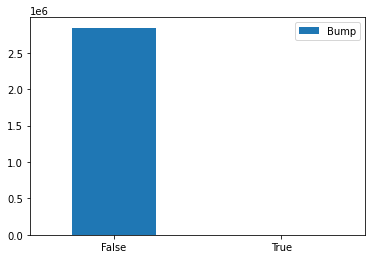

1021  accidents se sont déroulés près d'un  Bump
Soit  0.035883208415719445 % des enregistrements


<Figure size 432x288 with 0 Axes>

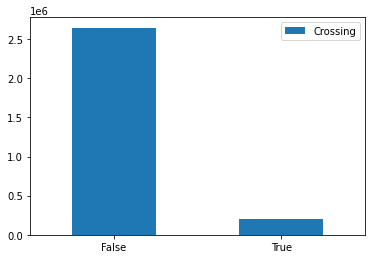

200212  accidents se sont déroulés près d'un  Crossing
Soit  7.03648278484625 % des enregistrements


<Figure size 432x288 with 0 Axes>

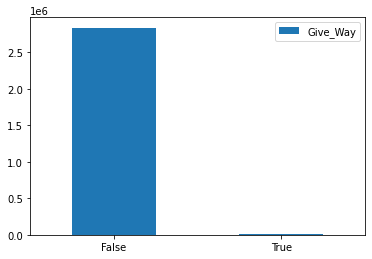

6868  accidents se sont déroulés près d'un  Give_Way
Soit  0.24137695925481015 % des enregistrements


<Figure size 432x288 with 0 Axes>

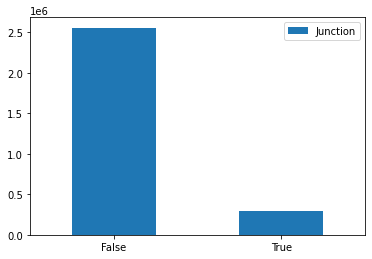

290505  accidents se sont déroulés près d'un  Junction
Soit  10.209844721653846 % des enregistrements


<Figure size 432x288 with 0 Axes>

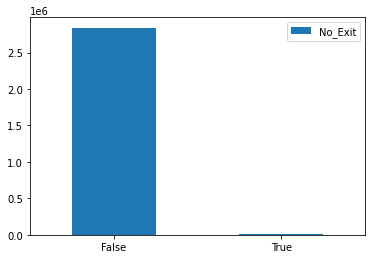

4294  accidents se sont déroulés près d'un  No_Exit
Soit  0.1509133172743382 % des enregistrements


<Figure size 432x288 with 0 Axes>

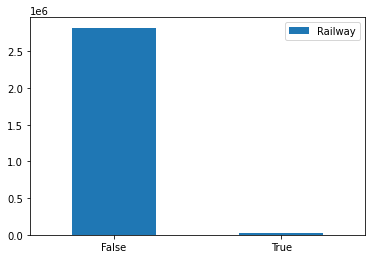

22631  accidents se sont déroulés près d'un  Railway
Soit  0.7953701171950507 % des enregistrements


<Figure size 432x288 with 0 Axes>

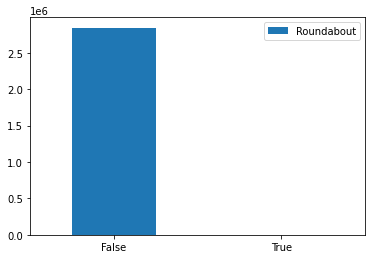

123  accidents se sont déroulés près d'un  Roundabout
Soit  0.004322854686712529 % des enregistrements


<Figure size 432x288 with 0 Axes>

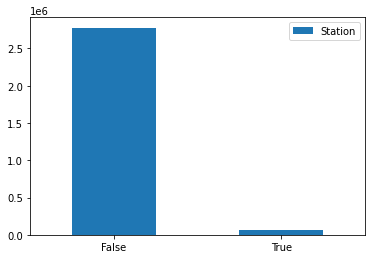

67995  accidents se sont déroulés près d'un  Station
Soit  2.3896951579107184 % des enregistrements


<Figure size 432x288 with 0 Axes>

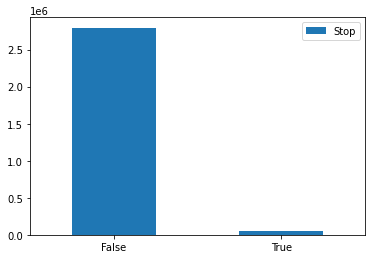

50400  accidents se sont déroulés près d'un  Stop
Soit  1.7713160667504995 % des enregistrements


<Figure size 432x288 with 0 Axes>

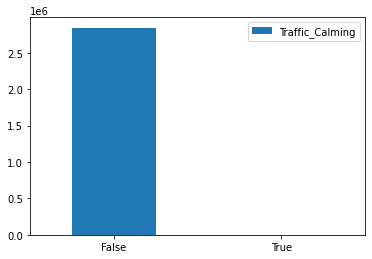

1712  accidents se sont déroulés près d'un  Traffic_Calming
Soit  0.060168514013429666 % des enregistrements


<Figure size 432x288 with 0 Axes>

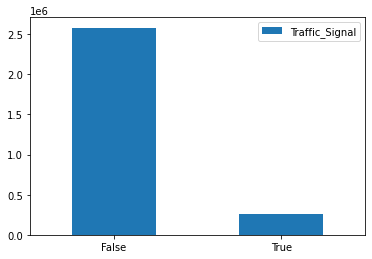

265263  accidents se sont déroulés près d'un  Traffic_Signal
Soit  9.322710591556305 % des enregistrements


<Figure size 432x288 with 0 Axes>

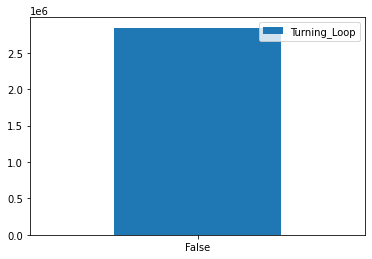

Aucun accident ne s'est déroulé près d'un  Turning_Loop


In [ ]:
marqueurs = ["Bump", "Crossing", "Give_Way", "Junction", "No_Exit", "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming", "Traffic_Signal", "Turning_Loop"]
max_accidents = 0
categorie_accidents = ""
max_pourcentage = 0
nombre_total_accidents_pcr = 0
for marqueur in marqueurs:
  compteur_valeurs_severite = dataframe[marqueur].value_counts()
  compteur_valeurs_severite = compteur_valeurs_severite.to_frame()
  fig = plt.figure()
  ax = compteur_valeurs_severite.plot.bar(rot=0)
  plt.show()

  # Cas où il n'y a pas de True dans les enregistrements
  if (len(compteur_valeurs_severite[marqueur])>1):
    nb_accidents = compteur_valeurs_severite[marqueur][valeurTrue(compteur_valeurs_severite)]
    pourcentage = nb_accidents/nombre_de_donnees*100
    print(nb_accidents, " accidents se sont déroulés près d'un ",marqueur)
    print("Soit ", pourcentage, "% des enregistrements")
    nombre_total_accidents_pcr += nb_accidents
    if (nb_accidents > max_accidents):
      max_accidents = nb_accidents
      categorie_accidents = marqueur
      max_pourcentage = pourcentage
  else:
    print("Aucun accident ne s'est déroulé près d'un ",marqueur)

In [ ]:
print("Les accidents avec un PCR sont majoritairement situés proches d'un ", categorie_accidents , " avec ", max_accidents , " enregistrements, soit ", max_pourcentage, "%")

Les accidents avec un PCR sont majoritairement situés proches d'un  Junction  avec  290505  enregistrements, soit  10.209844721653846 %


On voit que la plupart des accidents avec un PCR à proximité sont liés à la présence d'un carrefour.

Supposons maintenant que chaque accidents pour avoir au maximum un seul PCR à proximité. Cette supposition, bien que pas forcément vraie, nous permettra d'avoir un premier aperçu de la proportion. En effet, avec un simple dataframe, la détermination précise du nombre d'accidents avec au moins un perturbateur aurai pris beaucoup de temps. Nous ferons ce calcul dans les chapitres suivants, avec des outils plus à même de faire ces requêtes.

On va donc déterminer la proportion des accidents avec un PCR à proximité, grâce à la somme de tous les True parcourus précédemment. 

In [ ]:
pourcentage_total_accidents_pcr = nombre_total_accidents_pcr/nombre_de_donnees*100
print(nombre_total_accidents_pcr, " accidents se sont déroulés avec un PCR à proximité, soit ",  pourcentage_total_accidents_pcr, "%")

911024  accidents se sont déroulés avec un PCR à proximité, soit  32.01808429355768 %


On voit que plus de 32% des accidents se sont déroulés près d'un PCR, soit près d'1/3 des observations. Ce chiffre, bien qu'élevé, montre que ce n'est pas la majorité des accidents qui sont concernés par cet indicateur. 

## Perturbateurs de conduite liés aux conditions climatiques [PCC]

On va à présent recenser les Perturbateurs de Conduite liés aux conditions Climatiques (PCC). Pour cela, on utilisera les indices suivants :

* **Visibility(km)**
* **Wind_Speed(kmh)**
* **Precipitation(mm)** 
* **Weather_Condition**
* **Sunrise_Sunset**
* **Civil_Twilight**

On essaiera donc de terminer l'impact de ces indices sur le nombre d'accidents.

### Visibilité

In [ ]:
compteur_valeurs_visibilite_min = dataframe["Visibility(km)"].min()
compteur_valeurs_visibilite_min

0.0

In [ ]:
compteur_valeurs_visibilite_max = dataframe["Visibility(km)"].max()
compteur_valeurs_visibilite_max

225.30816000000002

La visibilité lors d'un accident varie entre 0 et 225km. On va maintenant regarder la distribution des données.

In [ ]:
def repartition_donnees_visibilite(data, min, max):
  nombre_partitions = 10
  facteur_additif = round((min + max) / nombre_partitions, 2)
  pas_fini = True
  borne_min = min
  borne_max = borne_min
  legende = []
  valeurs = []
  while pas_fini:
    borne_max += facteur_additif
    dataframe_bis = dataframe[dataframe['Visibility(km)'] < borne_max]
    dataframe_bis = dataframe_bis[dataframe_bis['Visibility(km)'] >= borne_min]
    valeurs.append(dataframe_bis.count()[0])
    legende.append(str(borne_min) + "<=Vis.<" + str(borne_max))
    borne_min += facteur_additif
    pas_fini = borne_max <= max
  fig,ax = plt.subplots(figsize=(20,12))
  plt.xticks(rotation = 'vertical')
  plt.title("Nombre de données par visibilité")
  plt.bar(legende, valeurs)

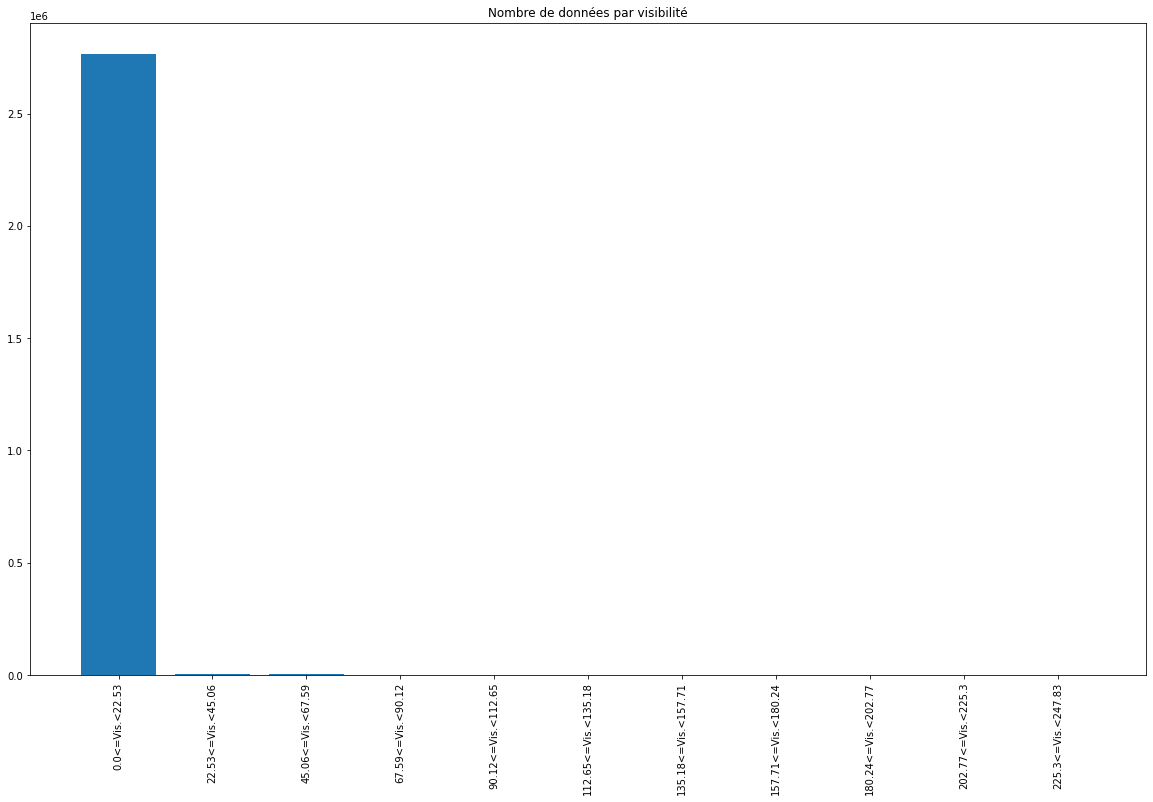

In [ ]:
repartition_donnees_visibilite(np.array(dataframe["Visibility(km)"]), float(compteur_valeurs_visibilite_min), float(compteur_valeurs_visibilite_max))

Comme pour la distance, la visibilté n'est vraiment pas bien répartie.

In [ ]:
valeurs_inferieures_a_2253 = dataframe[dataframe['Visibility(km)'] < 22.53].count()[0]
print(valeurs_inferieures_a_2253, " accidents qui ont eu lieu avec un visibilté de moins de 22.53 km (première borne du graphe pour 10 partitions)")
valeurs_superieures_a_2253 = dataframe[dataframe['Visibility(km)'] >= 22.53].count()[0]
print(valeurs_superieures_a_2253, " accidents qui ont eu lieu avec un visibilté d'au moins de 22.53 km (première borne du graphe pour 10 partitions)")

2766933  accidents qui ont eu lieu avec un visibilté de moins de 22.53 km (première borne du graphe pour 10 partitions)
7863  accidents qui ont eu lieu avec un visibilté d'au moins de 22.53 km (première borne du graphe pour 10 partitions)


On peut vraiment rapprocher le cas de la distance et de la visibilité, où on a environ la même distribution pour les données faibles et les autres, c'est à dire environ 2,8M données de valeurs faibles et moins de 10k données de valeurs plus fortes.

In [ ]:
valeurs_inferieures_a_1 = dataframe[dataframe['Visibility(km)'] < 15].count()[0]
print(valeurs_inferieures_a_1, " accidents qui ont eu lieu avec un visibilté de moins de 15 km")
valeurs_superieures_a_1 = dataframe[dataframe['Visibility(km)'] >= 15].count()[0]
print(valeurs_superieures_a_1, " accidents qui ont eu lieu avec un visibilté d'au moins de 15 km")

533368  accidents qui ont eu lieu avec un visibilté de moins de 15 km
2241428  accidents qui ont eu lieu avec un visibilté d'au moins de 15 km


On a 500k données de moins de 15km, et 2m200k données de plus de 15km.

In [ ]:
dataframe_bis = dataframe[dataframe['Visibility(km)'] >= 15]
valeurs_intervalles = dataframe_bis[dataframe_bis['Visibility(km)'] < 20].count()[0]
print(valeurs_intervalles, " accidents qui ont eu lieu avec un visibilté entre 15 et 20 km")

2230449  accidents qui ont eu lieu avec un visibilté entre 15 et 20 km


2.230M d'accidents ont eu lieu avec une visibilité entre 15 et 20km.

### Vitesse du vent

In [ ]:
compteur_valeurs_vent_min = dataframe["Wind_Speed(kmh)"].min()
compteur_valeurs_vent_min

0.0

In [ ]:
compteur_valeurs_vent_max = dataframe["Wind_Speed(kmh)"].max()
compteur_valeurs_vent_max

1749.3569280000002

La vitesse du vent lors d'un accident varie entre 0 et 1749km/h. On voit ici qu'il y a un problème sur les données, car le vent ne peut pas aller aussi vite. Il est noté [ici](https://www.meteo-paris.com/actualites/meteo-extreme-quels-sont-les-records-climatiques-dans-le-monde) que le maximum de la vitesse du vent enregistrée est de 408km/h. 

In [ ]:
dataframe[dataframe["Wind_Speed(kmh)"] > 408].count()[0]

8

Il y a 8 données supérieures à cette donnée, donc on sait que ces valeurs ne sont pas justes. On suppose que c'est un problème d'écriture de virgule et que ces données valent plus de 100km.

En se servant des données se trouvant [ici](https://vigilance.meteofrance.fr/fr/dangers-meteorologiques-vent-violent), on regardera les données où le vent est supérieur à 90km/h (moyenne entre 80 et 100km/h).

2687291  accidents qui ont eu lieu avec une vitesse de vent de moins de 90km/h
107  accidents qui ont eu lieu avec une vitesse de vent de plus de 90km/h


<BarContainer object of 2 artists>

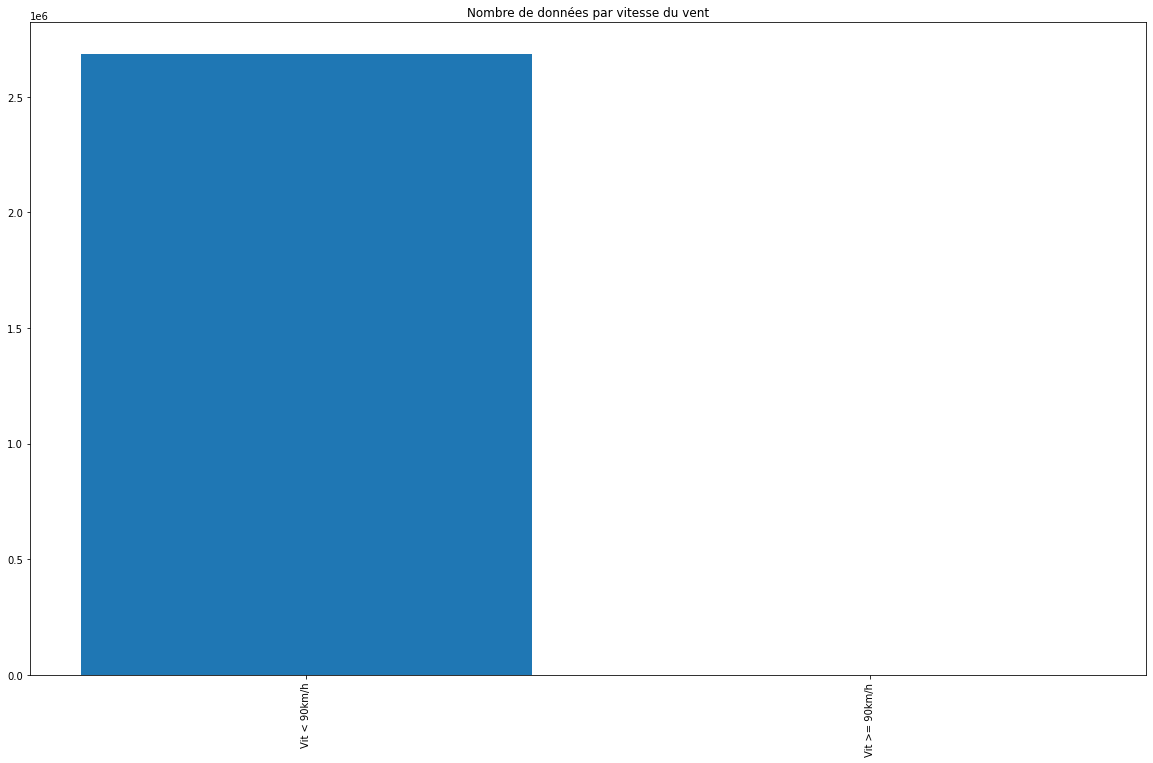

In [ ]:
valeurs_inferieures_a_90 = dataframe[dataframe['Wind_Speed(kmh)'] < 90].count()[0]
print(valeurs_inferieures_a_90, " accidents qui ont eu lieu avec une vitesse de vent de moins de 90km/h")
valeurs_superieures_a_90 = dataframe[dataframe['Wind_Speed(kmh)'] >= 90].count()[0]
print(valeurs_superieures_a_90, " accidents qui ont eu lieu avec une vitesse de vent de plus de 90km/h")

fig,ax = plt.subplots(figsize=(20,12))
plt.xticks(rotation = 'vertical')
plt.title("Nombre de données par vitesse du vent")
plt.bar(["Vit < 90km/h", "Vit >= 90km/h"], [valeurs_inferieures_a_90, valeurs_superieures_a_90])

2684531  accidents qui ont eu lieu avec une vitesse de vent de moins de 50km/h
2867  accidents qui ont eu lieu avec une vitesse de vent de plus de 50km/h


<BarContainer object of 2 artists>

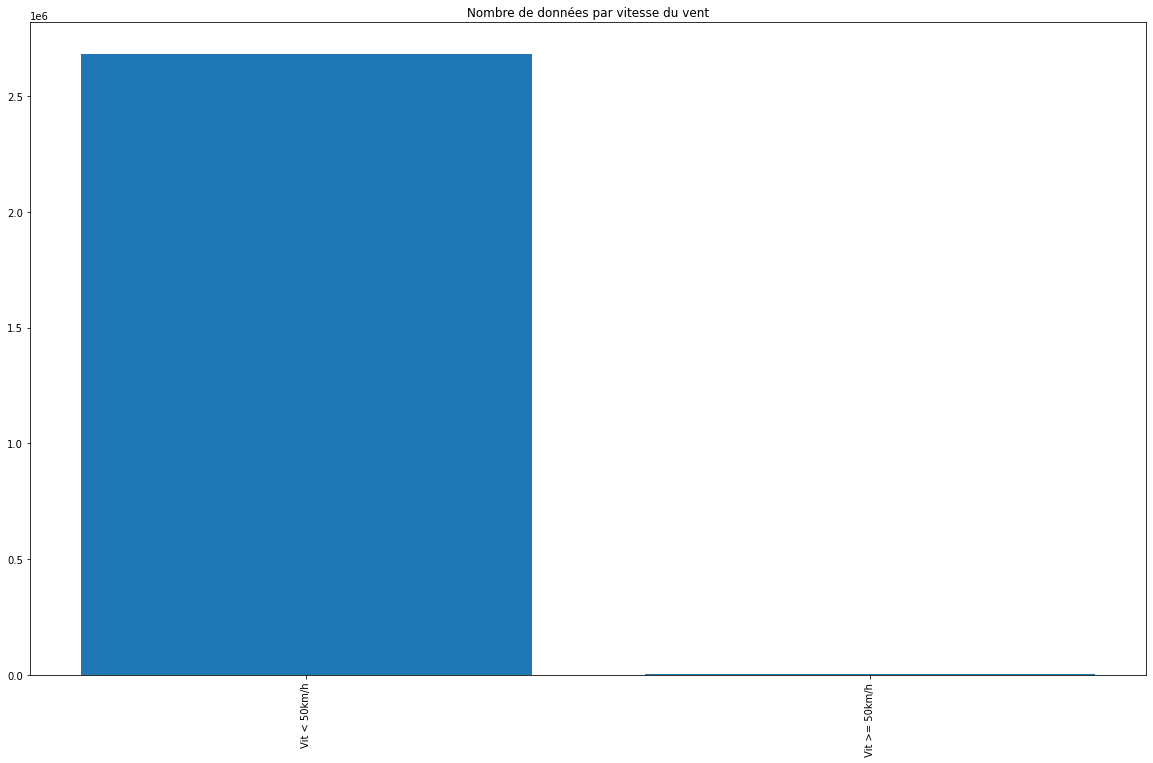

In [ ]:
valeurs_inferieures_a_50 = dataframe[dataframe['Wind_Speed(kmh)'] < 50].count()[0]
print(valeurs_inferieures_a_50, " accidents qui ont eu lieu avec une vitesse de vent de moins de 50km/h")
valeurs_superieures_a_50 = dataframe[dataframe['Wind_Speed(kmh)'] >= 50].count()[0]
print(valeurs_superieures_a_50, " accidents qui ont eu lieu avec une vitesse de vent de plus de 50km/h")

fig,ax = plt.subplots(figsize=(20,12))
plt.xticks(rotation = 'vertical')
plt.title("Nombre de données par vitesse du vent")
plt.bar(["Vit < 50km/h", "Vit >= 50km/h"], [valeurs_inferieures_a_50, valeurs_superieures_a_50])

On a une majorité écrasante des données qui sont inférieures à 50 km/h, ce qui signifie que ces accidents se sont déroulés sans réel problème impliqué par le vent.

### Précipitations

In [ ]:
compteur_valeurs_precipitation_min = dataframe["Precipitation(mm)"].min()
compteur_valeurs_precipitation_min

0.0

In [ ]:
compteur_valeurs_precipitation_max = dataframe["Precipitation(mm)"].max()
compteur_valeurs_precipitation_max

588.0

Là encore, on remarque que la borne min et la borne max sont très éloignés.

D'après [cet article](https://fr.wikipedia.org/wiki/Pluie), 
`On sépare l'intensité de la pluie en pluie faible (trace à 2 mm/h), modérée (2 mm/h à 7,6 mm/h) et forte (plus de 7,6 mm/h)`

2248378  accidents ont eu lieu avec une pluie faible.
39340  accidents ont eu lieu avec une pluie modérée.
8166  accidents ont eu lieu avec une pluie forte.


<BarContainer object of 3 artists>

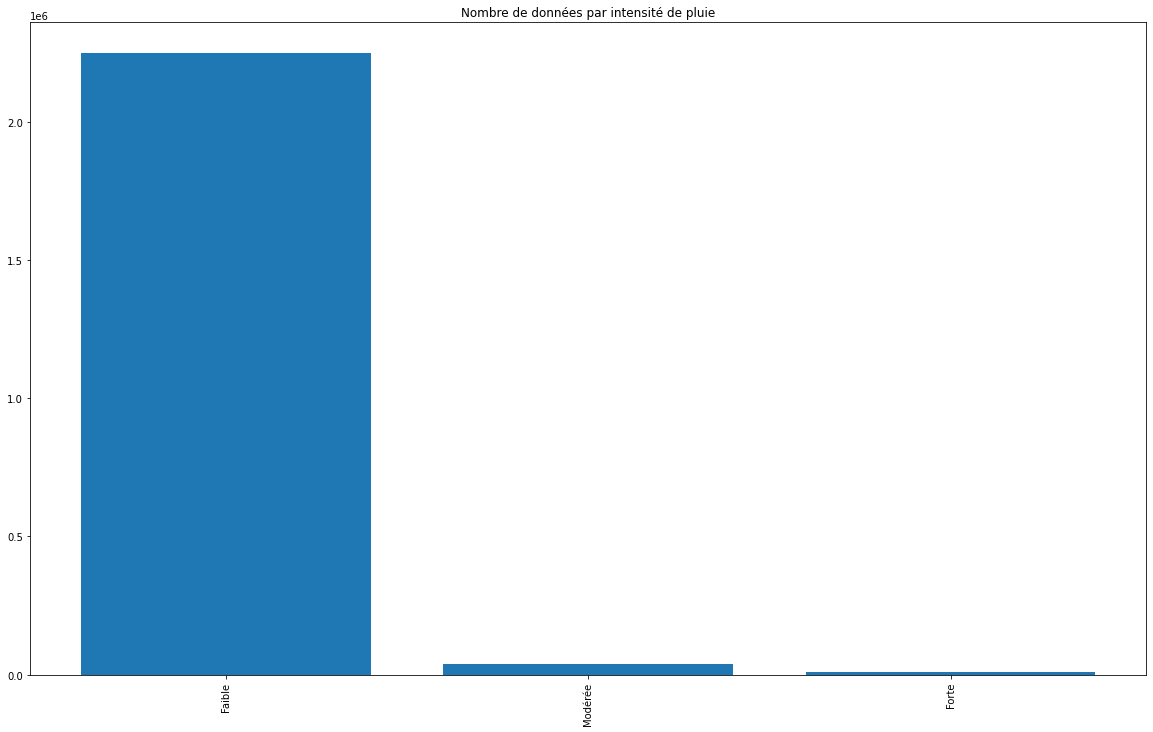

In [ ]:
pluie_faible = dataframe[dataframe['Precipitation(mm)'] < 2].count()[0]
print(pluie_faible, " accidents ont eu lieu avec une pluie faible.")
pluie_moderee = dataframe[dataframe['Precipitation(mm)'] >= 2]
pluie_moderee = pluie_moderee[pluie_moderee['Precipitation(mm)'] < 7.6].count()[0]
print(pluie_moderee, " accidents ont eu lieu avec une pluie modérée.")
pluie_forte = dataframe[dataframe['Precipitation(mm)'] >= 7.6].count()[0]
print(pluie_forte, " accidents ont eu lieu avec une pluie forte.")


fig,ax = plt.subplots(figsize=(20,12))
plt.xticks(rotation = 'vertical')
plt.title("Nombre de données par intensité de pluie")
plt.bar(["Faible", "Modérée", "Forte"], [pluie_faible, pluie_moderee, pluie_forte])

On remarque que l'écrasante majorité des accidents se sont déroulés sous une pluie faible.

### Conditions climatiques

In [ ]:
dataframe["Weather_Condition"]

0             Light Rain
1             Light Rain
2               Overcast
3               Overcast
4             Light Rain
               ...      
2845337             Fair
2845338             Fair
2845339    Partly Cloudy
2845340             Fair
2845341             Fair
Name: Weather_Condition, Length: 2845342, dtype: string

Les 10 conditions climatiques pour lesquelles il y a eu le plus d'accidents :  ['Fog' 'Light Snow' 'Clear' 'Scattered Clouds' 'Light Rain' 'Overcast'
 'Partly Cloudy' 'Mostly Cloudy' 'Cloudy' 'Fair']
Avec respectivement ces nombres d'accidents :  [  41226   43752  173823   45132  128403   84882  249939  363959  348767
 1107194]


<BarContainer object of 10 artists>

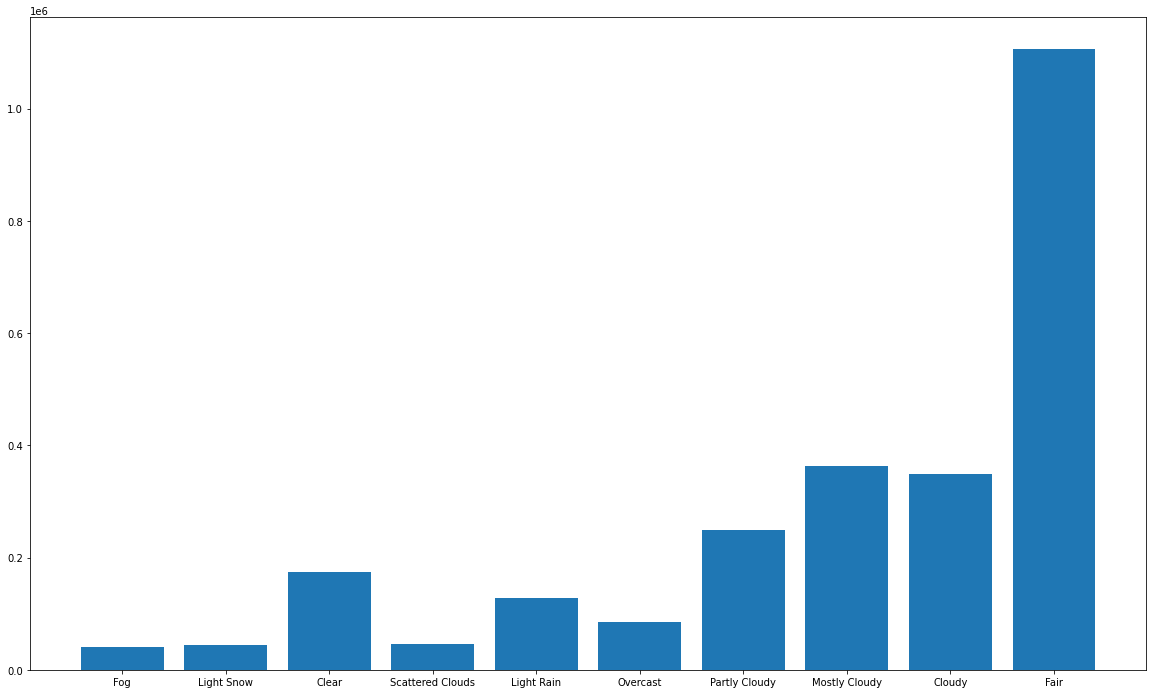

In [ ]:
conditions = dataframe["Weather_Condition"].unique()
nombre_accidents_par_condition = []
for condition in conditions:
    nombre_accidents_par_condition.append(dataframe[dataframe['Weather_Condition']== condition].count()['Weather_Condition'])

indices_top_10 = np.argpartition(nombre_accidents_par_condition, -10)[-10:]
top_10 = np.array(nombre_accidents_par_condition)[indices_top_10]
noms_top_10 = np.array(conditions)[indices_top_10]
print("Les 10 conditions climatiques pour lesquelles il y a eu le plus d'accidents : ", noms_top_10)
print("Avec respectivement ces nombres d'accidents : ", top_10)
fig,ax = plt.subplots(figsize=(20,12))
plt.bar(noms_top_10, top_10)

In [ ]:
condition_max = top_10.max()
indice_condition_max = list(top_10).index(condition_max)
string_condition_max = noms_top_10[indice_condition_max]
pourcentage_condition_max = condition_max / nombre_de_donnees * 100

print("La condition climatique pour laquelle il y a le plus d'accidents est : ", string_condition_max, " avec ", condition_max, " accidents.")
print("Cela représente ", pourcentage_condition_max, "% des données totales.")

La condition climatique pour laquelle il y a le plus d'accidents est :  Fair  avec  1107194  accidents.
Cela représente  38.912510341463346 % des données totales.


Près de 40% des accidents ont eu lieu sous un temps clair.

### Jour et nuit (basé sur sunrise/sunset)

<BarContainer object of 2 artists>

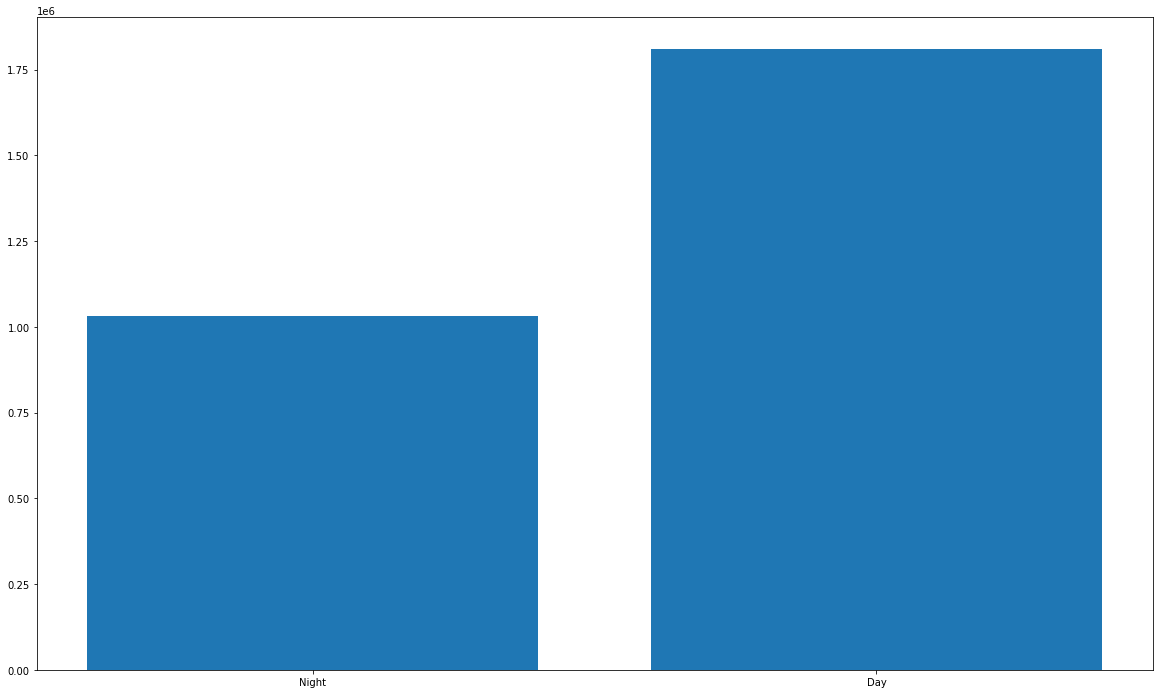

In [ ]:
sun = dataframe["Sunrise_Sunset"].unique()
sun = [s for s in sun if not(pd.isnull(s)) == True]
nombre_accidents_par_s = []
for s in sun:
    nombre_accidents_par_s.append(dataframe[dataframe['Sunrise_Sunset']== s].count()['Sunrise_Sunset'])

fig,ax = plt.subplots(figsize=(20,12))
plt.bar(sun, nombre_accidents_par_s)

La majorité des accidents se sont passés le jour. Il est possible que nous pensions que la plupart des accidents se déroulent la nuit, avec la fatigue et le manque de visibilité. Cependant, le résultat parait logique, car il y a plus de traffic le jour, et donc plus de risques d'accidents.

### Jour et nuit (basé sur le crépuscule civil)

<BarContainer object of 2 artists>

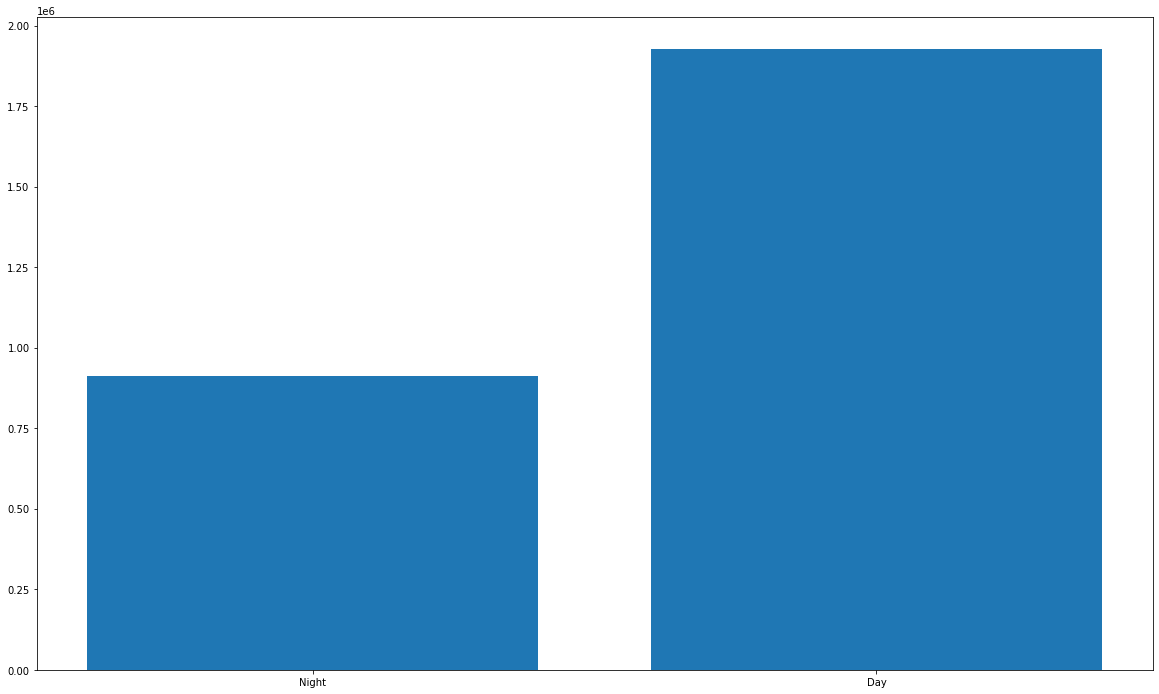

In [ ]:
sun2 = dataframe["Civil_Twilight"].unique()
sun2 = [s for s in sun2 if not(pd.isnull(s)) == True]
nombre_accidents_par_s2 = []
for s in sun2:
    nombre_accidents_par_s2.append(dataframe[dataframe['Civil_Twilight']== s].count()['Civil_Twilight'])

fig,ax = plt.subplots(figsize=(20,12))
plt.bar(sun, nombre_accidents_par_s2)

On remarque un décalage entre les valeurs Jour et Nuit pour ces deux indicateurs. En effet, ils n'utilisent pas la même règle de décision. Cependant, les données sont comparables 

In [ ]:
condition_jour = "Day"

indice_condition_jour = list(sun).index(condition_jour)
indice_condition_jour2 = list(sun2).index(condition_jour)

nombre_jours = nombre_accidents_par_s[indice_condition_jour]
nombre_jours2 = nombre_accidents_par_s2[indice_condition_jour2]

print("Il y a ", nombre_jours, " données de Jour dans le premier indice")
print("Il y a ", nombre_jours2, " données de Jour dans le deuxième indice")

Il y a  1811935  données de Jour dans le premier indice
Il y a  1929103  données de Jour dans le deuxième indice


On note un décalage de 100 000 données, ce qui n'est pas très significatif sur un jeu de données de 2.8M de données, mais qui peut quand même avoir son importance.

# Interprétation des données avec Spark

Dans ce chapitre, nous ferons une analyse des données à l'aide de Spark, et du dataframe généré.

## Représentation basique des données

In [ ]:
nombre_de_donnees_spark = dataframe_spark.count()
print("Il y a ", nombre_de_donnees_spark, " données dans le dataframe Spark")

Il y a  2845342  données dans le dataframe Spark


In [ ]:
# Attention, cette cellule met 4min30 à s'exécuter. Le but est simplement de comparer si les deux jeux de données sont identiques
dataframe_spark.describe().show()

+-------+--------+-------------------+-----------------+------------------+-----------------+------------------+------------------+--------------------+-----------------+----------+-------+----------+---------+-------+-----------------+-------+----------+------------+-------------------+------------------+------------------+-----------------+------------------+------------------+--------------+------------------+-------------------+------------------+--------------+--------------+-----------------+---------------------+
|summary|      ID|           Severity|        Start_Lat|         Start_Lng|          End_Lat|           End_Lng|      Distance(km)|         Description|           Number|    Street|   Side|      City|   County|  State|          Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|    Temperature(C)|     Wind_Chill(C)|      Humidity(%)|      Pressure(in)|    Visibility(km)|Wind_Direction|   Wind_Speed(kmh)|  Precipitation(mm)| Weather_Condition|Sunrise_Sunset|Civi

## Répartition de la sévérité

In [ ]:
maximum_severite = dataframe_spark.agg({"Severity": "max"}).collect()[0]["max(Severity)"]
minimum_severite = dataframe_spark.agg({"Severity": "min"}).collect()[0]["min(Severity)"]
print("Les niveaux de sévérité de l'accident vont de ", minimum_severite, " à ", maximum_severite)

Les niveaux de sévérité de l'accident vont de  1  à  4


In [ ]:
compteur_valeurs_severite = dataframe_spark.groupBy("Severity").count().orderBy("count")
compteur_valeurs_severite.show()

+--------+-------+
|Severity|  count|
+--------+-------+
|       1|  26053|
|       4| 131193|
|       3| 155105|
|       2|2532991|
+--------+-------+



Comme pour le dataframe Spark, on remarque que les données ne sont vraiment pas réparties uniformément, et il y a beaucoup plus de données de sévérité 2, quand les autres sévérités sont globalement dans le même ordre de grandeur.

## Accidents par état

In [ ]:
compteur_valeurs_etats = dataframe_spark.groupBy("State").count().sort('count', ascending=False)
compteur_valeurs_etats.show()

+-----+------+
|State| count|
+-----+------+
|   CA|795868|
|   FL|401388|
|   TX|149037|
|   OR|126341|
|   VA|113535|
|   NY|108049|
|   PA| 99975|
|   MN| 97185|
|   NC| 91362|
|   SC| 89216|
|   MD| 65085|
|   AZ| 56504|
|   NJ| 52902|
|   TN| 52613|
|   UT| 49193|
|   LA| 47232|
|   IL| 47105|
|   MI| 43843|
|   GA| 40086|
|   WA| 32554|
+-----+------+
only showing top 20 rows



On a les même résultats qu'avec pandas. On remarque que la grande majorité des accidents ont lieu en Californie.

## Détermination du minimum et du maximum de la distance de l'accident

In [ ]:
maximum = dataframe_spark.agg({"Distance(km)": "max"}).collect()[0]["max(Distance(km))"]
minimum = dataframe_spark.agg({"Distance(km)": "min"}).collect()[0]["min(Distance(km))"]
print("Les distances de l'accident vont de ", minimum, " à ", maximum, "kilomètres")

Les distances de l'accident vont de  0.0  à  249.74765798400003 kilomètres


In [ ]:
valeurs_inferieures_a_1 = dataframe_spark.filter('`Distance(km)` < 1').count()
print(valeurs_inferieures_a_1, " accidents qui ont impacté moins de 1 km")
valeurs_superieures_a_1 = dataframe_spark.filter('`Distance(km)` >= 1').count()
print(valeurs_superieures_a_1, " accidents qui ont impacté au moins 1 km")

2003262  accidents qui ont impacté moins de 1 km
842080  accidents qui ont impacté au moins 1 km


## Perturbateurs de conduite liés à la route [PCR]

In [ ]:
marqueurs = ["Bump", "Crossing", "Give_Way", "Junction", "No_Exit", "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming", "Traffic_Signal", "Turning_Loop"]
for marqueur in marqueurs:
  print(marqueur + " : ")
  val1 = dataframe_spark.filter('`'+ marqueur + '` = True').count()
  print("True : ", val1)
  val2 = dataframe_spark.filter('`'+ marqueur + '` = False').count()
  print("False : ", val2)
  proportion = val1 / (val1 + val2) * 100
  print("Proportion de True sur les données renseignées : ", proportion, "%")
  print()

Bump : 
True :  1021
False :  2844321
Proportion de True sur les données renseignées :  0.035883208415719445 %

Crossing : 
True :  200212
False :  2645130
Proportion de True sur les données renseignées :  7.03648278484625 %

Give_Way : 
True :  6868
False :  2838474
Proportion de True sur les données renseignées :  0.24137695925481015 %

Junction : 
True :  290505
False :  2554837
Proportion de True sur les données renseignées :  10.209844721653846 %

No_Exit : 
True :  4294
False :  2841048
Proportion de True sur les données renseignées :  0.1509133172743382 %

Railway : 
True :  22631
False :  2822711
Proportion de True sur les données renseignées :  0.7953701171950507 %

Roundabout : 
True :  123
False :  2845219
Proportion de True sur les données renseignées :  0.004322854686712529 %

Station : 
True :  67995
False :  2777347
Proportion de True sur les données renseignées :  2.3896951579107184 %

Stop : 
True :  50400
False :  2794942
Proportion de True sur les données renseignées

On voit que la plupart des accidents avec un PCR à proximité sont liés à la présence d'un carrefour.

On va maintenant déterminer la proportion des accidents avec un PCR à proximité. 

In [ ]:
marqueurs = ["Bump", "Crossing", "Give_Way", "Junction", "No_Exit", "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming", "Traffic_Signal", "Turning_Loop"]
chaine = ""
cpt = 0
for marqueur in marqueurs:
  if (cpt > 0):
    chaine += " OR "
  chaine += '`'+ marqueur + '` = True'
  cpt += 1
nombre_accidents_avec_pcr = dataframe_spark.filter(chaine).count()
print(nombre_accidents_avec_pcr, " accidents ont eu lieu avec un PCR a proximité")


723942  accidents ont eu lieu avec un PCR a proximité


Comme supposé dans le chapitre précédent, nous trouvons un nombre différent dans le nombre d'accidents ayant True pour au moins un PCR a proximité.

En effet, pour la partie Pandas, nous avons fait la somme des True, et supposé que si un accident à un PCR à True, il a les autres à False, pour ne pas alourdir les calculs en Pandas. Avec notre Dataframe Spark, nous avons repéré les lignes qui ont au moins un PCR à True, en vérifiant pour chaque PCR s'il est à True et grâce à la condition "OR". Ainsi, cette formule prend en compte les accidents situés à proximité des plusieurs PCR.

Ainsi, on peut dire que 723942 accidents ont eu lieu avec au moins un PCR à proximité (contre 911024 estimé en Pandas).

In [ ]:
pourcentage_pcr = nombre_accidents_avec_pcr/nombre_de_donnees*100
print("Cela correspond à", pourcentage_pcr, "% des données totales")

Cela correspond à 25.44305746022798 % des données totales


## Perturbateurs de conduite liés aux conditions climatiques [PCC]

### Visibilité

In [ ]:
maximum = dataframe_spark.agg({"Visibility(km)": "max"}).collect()[0]["max(Visibility(km))"]
minimum = dataframe_spark.agg({"Visibility(km)": "min"}).collect()[0]["min(Visibility(km))"]
print("La visibilité lors des accidents varient de ", minimum, " à ", maximum, 'km')

La visibilité lors des accidents varient de  0.0  à  225.30816000000002 km


In [ ]:
def repartition_donnees_visibilite(data, min, max):
  nombre_partitions = 10
  facteur_additif = round((min + max) / nombre_partitions, 2)
  pas_fini = True
  borne_min = min
  borne_max = borne_min
  legende = []
  valeurs = []
  while pas_fini:
    borne_max += facteur_additif
    dataframe_bis = data.filter('`Visibility(km)` < '+ str(borne_max)).filter('`Visibility(km)` >= '+ str(borne_min)).count()
    print(str(borne_min) + "km <= Vis. < " + str(borne_max) + "km : ")
    print(dataframe_bis)
    borne_min += facteur_additif
    pas_fini = borne_max <= max
    print()

In [ ]:
repartition_donnees_visibilite(dataframe_spark, minimum, maximum)

0.0km <= Vis. < 22.53km : 
2766933

22.53km <= Vis. < 45.06km : 
4292

45.06km <= Vis. < 67.59km : 
2171

67.59km <= Vis. < 90.12km : 
943

90.12km <= Vis. < 112.65km : 
84

112.65km <= Vis. < 135.18km : 
318

135.18km <= Vis. < 157.71km : 
9

157.71km <= Vis. < 180.24km : 
39

180.24km <= Vis. < 202.77km : 
4

202.77km <= Vis. < 225.3km : 
1

225.3km <= Vis. < 247.83km : 
2



La visibilité n'est vraiment pas bien répartie.

In [ ]:
valeurs_inferieures_a_2253 = dataframe_spark.filter('`Visibility(km)` < 22.53').count()
valeurs_superieures_a_2253 = dataframe_spark.filter('`Visibility(km)` >= 22.53').count()
print(valeurs_inferieures_a_2253, " accidents avec une visibilté de moins de 22.53 km (première borne du graphe pour 10 partitions)")
print(valeurs_superieures_a_2253, " accidents avec une visibilté d'au moins 22.53 km (première borne du graphe pour 10 partitions)")

2766933  accidents avec une visibilté de moins de 22.53 km (première borne du graphe pour 10 partitions)
7863  accidents avec une visibilté d'au moins 22.53 km (première borne du graphe pour 10 partitions)


In [ ]:
valeurs_inferieures = dataframe_spark.filter('`Visibility(km)` < 15').count()
valeurs_superieures = dataframe_spark.filter('`Visibility(km)` >= 15').count()
print(valeurs_inferieures, " accidents avec une visibilté de moins de 15km")
print(valeurs_superieures, " accidents avec une visibilté d'au moins 15km")

533368  accidents avec une visibilté de moins de 15km
2241428  accidents avec une visibilté d'au moins 15km


In [ ]:
val = dataframe_spark.filter('`Visibility(km)` > 15 AND `Visibility(km)` <= 20').count()
print(val, " accidents avec une visibilté entre 15 et 20km")

2230449  accidents avec une visibilté entre 15 et 20km


2.2M d'accidents, donc la grande majorité des accidents, ont eu lieu avec une visibilité entre 15 et 20 km.

### Vitesse du vent

In [ ]:
maximum = dataframe_spark.agg({"Wind_Speed(kmh)": "max"}).collect()[0]["max(Wind_Speed(kmh))"]
minimum = dataframe_spark.agg({"Wind_Speed(kmh)": "min"}).collect()[0]["min(Wind_Speed(kmh))"]
print("La vitesse du vent lors des accidents varient de ", minimum, " à ", maximum, 'km/h')

La vitesse du vent lors des accidents varient de  0.0  à  1749.3569280000002 km/h


La vitesse du vent lors d'un accident varie entre 0 et 1749km/h. On voit ici qu'il y a un problème sur les données, car le vent ne peut pas aller aussi vite. Il est noté [ici](https://www.meteo-paris.com/actualites/meteo-extreme-quels-sont-les-records-climatiques-dans-le-monde) que le maximum de la vitesse du vent enregistrée est de 408km/h.

In [ ]:
print(dataframe_spark.filter("`Wind_Speed(kmh)` > 408").count())

8


Il y a 8 données supérieures à cette donnée, donc on sait que ces valeurs ne sont pas justes. On suppose que c'est un problème d'écriture de virgule et que ces données valent plus de 100km.

En se servant des données se trouvant [ici](https://vigilance.meteofrance.fr/fr/dangers-meteorologiques-vent-violent), on regardera les données où le vent est supérieur à 90km/h (moyenne entre 80 et 100km/h).

In [ ]:
borne_inf = dataframe_spark.filter("`Wind_Speed(kmh)` < 90").count()
borne_sup = dataframe_spark.filter("`Wind_Speed(kmh)` >= 90").count()
print(str(borne_inf) + " accidents à moins de 90kmh ; " + str(borne_sup) + " accidents à plus de 90kmh")

2687291 accidents à moins de 90kmh ; 107 accidents à plus de 90kmh


In [ ]:
borne_inf = dataframe_spark.filter("`Wind_Speed(kmh)` < 50").count()
borne_sup = dataframe_spark.filter("`Wind_Speed(kmh)` >= 50").count()
print(str(borne_inf) + " accidents à moins de 50kmh ; " + str(borne_sup) + " accidents à plus de 50kmh")

2684531 accidents à moins de 50kmh ; 2867 accidents à plus de 50kmh


In [ ]:
borne_inf = dataframe_spark.filter("`Wind_Speed(kmh)` < 20").count()
borne_sup = dataframe_spark.filter("`Wind_Speed(kmh)` >= 20").count()
print(str(borne_inf) + " accidents à moins de 20kmh ; " + str(borne_sup) + " accidents à plus de 20kmh")

2231706 accidents à moins de 20kmh ; 455692 accidents à plus de 20kmh


### Précipitations

In [ ]:
maximum = dataframe_spark.agg({"Precipitation(mm)": "max"}).collect()[0]["max(Precipitation(mm))"]
minimum = dataframe_spark.agg({"Precipitation(mm)": "min"}).collect()[0]["min(Precipitation(mm))"]
print("Les précipitations lors des accidents varient de ", minimum, " à ", maximum, 'mm')

Les précipitations lors des accidents varient de  0.0  à  588.0 mm


In [ ]:
pluie_faible = dataframe_spark.filter('`Precipitation(mm)` < 2').count()
print(pluie_faible, " accidents ont eu lieu avec une pluie faible.")
pluie_moderee = dataframe_spark.filter('`Precipitation(mm)` >= 2 AND `Precipitation(mm)` < 7.6').count()
print(pluie_moderee, " accidents ont eu lieu avec une pluie modérée.")
pluie_forte = dataframe_spark.filter('`Precipitation(mm)` >= 7.6').count()
print(pluie_forte, " accidents ont eu lieu avec une pluie forte.")

2248378  accidents ont eu lieu avec une pluie faible.
39340  accidents ont eu lieu avec une pluie modérée.
8166  accidents ont eu lieu avec une pluie forte.


### Conditions climatiques

In [ ]:
compteur_valeurs = dataframe_spark.groupBy("Weather_Condition").count().sort('count', ascending=False)
compteur_valeurs.show()

+--------------------+-------+
|   Weather_Condition|  count|
+--------------------+-------+
|                Fair|1107194|
|       Mostly Cloudy| 363959|
|              Cloudy| 348767|
|       Partly Cloudy| 249939|
|               Clear| 173823|
|          Light Rain| 128403|
|            Overcast|  84882|
|                null|  70636|
|    Scattered Clouds|  45132|
|          Light Snow|  43752|
|                 Fog|  41226|
|                Haze|  36354|
|                Rain|  31044|
|        Fair / Windy|  15195|
|          Heavy Rain|  11824|
|               Smoke|   7200|
|       Light Drizzle|   7041|
|Thunder in the Vi...|   6944|
|      Cloudy / Windy|   6839|
|             T-Storm|   6546|
+--------------------+-------+
only showing top 20 rows



La grande majorité des accidents ont lieu avec un temps clair. De plus, la pluie arrive en sizième position, et ce n'est qu'une pluie légère.

### Jour et nuit (basé sur sunrise/sunset)

In [ ]:
compteur_valeurs = dataframe_spark.groupBy("Sunrise_Sunset").count().sort('count', ascending=False)
compteur_valeurs.show()

+--------------+-------+
|Sunrise_Sunset|  count|
+--------------+-------+
|           Day|1811935|
|         Night|1030540|
|          null|   2867|
+--------------+-------+



La majorité des accidents se déroulent le jour, même si on n'a pas un écart aussi grand que pour d'autre variables. Il y a cependant 1.8 fois plus d'accidents de jours que de nuit. C'est lié au fait qu'il y a plus de traffic le jour, et donc plus de risques d'accidents.

### Jour et nuit (basé sur le crépuscule civil)

In [ ]:
compteur_valeurs = dataframe_spark.groupBy("Civil_Twilight").count().sort('count', ascending=False)
compteur_valeurs.show()

+--------------+-------+
|Civil_Twilight|  count|
+--------------+-------+
|           Day|1929103|
|         Night| 913372|
|          null|   2867|
+--------------+-------+



On remarque un décalage entre les valeurs Jour et Nuit pour ces deux indicateurs. En effet, ils n'utilisent pas la même règle de décision. Cependant, les données sont comparables car les résultats sont proches.

# Interprétation des données avec BigQuery

On va maintenant interpréter les données avec Big Query, et utiliser les différentes fonctionnalités du langage pour conserver certains résultats utiles dans des tables. Vous pouvez accéder à l'interface graphique de GBQ [ici](https://console.cloud.google.com).

## Préparation des données

On renomme les colonnes où il y a des parenthèses, en les remplaçant par des "_", car les parenthèses ne sont pas bien gérées par BigQuery.

In [ ]:
dataframe.dtypes

ID                               string
Severity                          int64
Start_Time               datetime64[ns]
End_Time                 datetime64[ns]
Start_Lat                       float64
Start_Lng                       float64
End_Lat                         float64
End_Lng                         float64
Distance(km)                    float64
Description                      string
Number                          float64
Street                           string
Side                             string
City                             string
County                           string
State                            string
Zipcode                          string
Country                          string
Timezone                         string
Airport_Code                     string
Weather_Timestamp                string
Temperature(C)                  float64
Wind_Chill(C)                   float64
Humidity(%)                     float64
Pressure(in)                    float64


In [ ]:
dataframe_big_query = dataframe.rename({'Distance(km)': 'Distance_km_', 'Temperature(C)': 'Temperature_C_', 'Wind_Chill(C)': 'Wind_Chill_C_'}, axis='columns')
dataframe_big_query = dataframe_big_query.rename({'Humidity(%)': 'Humidity_prct_', 'Pressure(in)': 'Pressure_in_', 'Visibility(km)': 'Visibility_km_'}, axis='columns')
dataframe_big_query = dataframe_big_query.rename({'Wind_Speed(kmh)': 'Wind_Speed_kmh_', 'Precipitation(mm)': 'Precipitation_mm_'}, axis='columns')

On convertit les timestamp[ns] en timestamp[s], car les premiers cités sont sources d'erreurs lors du loadJobConfig.

In [ ]:
dataframe_big_query['Start_Time'] =dataframe_big_query['Start_Time'].astype('datetime64[s]')
dataframe_big_query['End_Time'] =dataframe_big_query['End_Time'].astype('datetime64[s]')

In [ ]:
dataframe_big_query.dtypes

ID                               string
Severity                          int64
Start_Time               datetime64[ns]
End_Time                 datetime64[ns]
Start_Lat                       float64
Start_Lng                       float64
End_Lat                         float64
End_Lng                         float64
Distance_km_                    float64
Description                      string
Number                          float64
Street                           string
Side                             string
City                             string
County                           string
State                            string
Zipcode                          string
Country                          string
Timezone                         string
Airport_Code                     string
Weather_Timestamp                string
Temperature_C_                  float64
Wind_Chill_C_                   float64
Humidity_prct_                  float64
Pressure_in_                    float64


In [ ]:
colonnes_big_query = dataframe_big_query.columns

## Insertion des données dans Big Query

On insère la table dans Big Query. On initialise le paramètre `write_disposition` à "WRITE_TRUNCATE" pour que la table se crée à chaque fois, et que les données ne s'empilent pas à la suite.

In [ ]:
client = bigquery.Client(project="big-data-fintech-labat")

In [ ]:
table_id = "tables_projet_labat.US_accidents"

job_config = bigquery.LoadJobConfig(
    schema=[
        bigquery.SchemaField("ID", "STRING"),
        bigquery.SchemaField("Severity", "INTEGER"),
        bigquery.SchemaField("Start_Time", "TIMESTAMP"),
        bigquery.SchemaField("End_Time", "TIMESTAMP"),
        bigquery.SchemaField("Start_Lat", "FLOAT"),
        bigquery.SchemaField("Start_Lng", "FLOAT"),
        bigquery.SchemaField("End_Lat", "FLOAT"),
        bigquery.SchemaField("End_Lng", "FLOAT"),
        bigquery.SchemaField("Distance_km_", "FLOAT"),
        bigquery.SchemaField("Description", "STRING"),
        bigquery.SchemaField("Number", "FLOAT"),
        bigquery.SchemaField("Street", "STRING"),
        bigquery.SchemaField("Side", "STRING"),
        bigquery.SchemaField("City", "STRING"),
        bigquery.SchemaField("County", "STRING"),
        bigquery.SchemaField("State", "STRING"),
        bigquery.SchemaField("Zipcode", "STRING"),
        bigquery.SchemaField("Country", "STRING"),
        bigquery.SchemaField("Timezone", "STRING"),
        bigquery.SchemaField("Airport_Code", "STRING"),
        bigquery.SchemaField("Weather_Timestamp", "STRING"),
        bigquery.SchemaField("Temperature_C_", "FLOAT"),
        bigquery.SchemaField("Wind_Chill_C_", "FLOAT"),
        bigquery.SchemaField("Humidity_prct_", "FLOAT"),
        bigquery.SchemaField("Pressure_in_", "FLOAT"),
        bigquery.SchemaField("Visibility_km_", "FLOAT"),
        bigquery.SchemaField("Wind_Direction", "STRING"),
        bigquery.SchemaField("Wind_Speed_kmh_", "FLOAT"),
        bigquery.SchemaField("Precipitation_mm_", "FLOAT"),
        bigquery.SchemaField("Weather_Condition", "STRING"),
        bigquery.SchemaField("Amenity", "BOOLEAN"),
        bigquery.SchemaField("Bump", "BOOLEAN"),
        bigquery.SchemaField("Crossing", "BOOLEAN"),
        bigquery.SchemaField("Give_Way", "BOOLEAN"),
        bigquery.SchemaField("Junction", "BOOLEAN"),
        bigquery.SchemaField("No_Exit", "BOOLEAN"),
        bigquery.SchemaField("Railway", "BOOLEAN"),
        bigquery.SchemaField("Roundabout", "BOOLEAN"),
        bigquery.SchemaField("Station", "BOOLEAN"),
        bigquery.SchemaField("Stop", "BOOLEAN"),
        bigquery.SchemaField("Traffic_Calming", "BOOLEAN"),
        bigquery.SchemaField("Traffic_Signal", "BOOLEAN"),
        bigquery.SchemaField("Turning_Loop", "BOOLEAN"),
        bigquery.SchemaField("Sunrise_Sunset", "STRING"),
        bigquery.SchemaField("Civil_Twilight", "STRING"),
        bigquery.SchemaField("Nautical_Twilight", "STRING"),
        bigquery.SchemaField("Astronomical_Twilight", "STRING"),
    ],
    write_disposition='WRITE_TRUNCATE'
)

load_job = client.load_table_from_dataframe(
  dataframe_big_query,
  table_id,
  job_config=job_config
)

load_job.result()  # Wait for the job to complete.

table = client.get_table(table_id)
print("Loaded {} rows to table {}".format(table.num_rows, table_id))

Loaded 2845342 rows to table tables_projet_labat.US_accidents


## Représentation basique des données

### Nombre de données

In [ ]:
job_config = bigquery.QueryJobConfig(
    # Run at batch priority, which won't count toward concurrent rate limit.
    priority=bigquery.QueryPriority.BATCH
)

sql = """
    SELECT COUNT(ID) AS Nombre_de_donnees
    FROM tables_projet_labat.US_accidents
"""

# Start the query, passing in the extra configuration.
query_job = client.query(sql, job_config=job_config)  # Make an API request.

while(query_job.state != "DONE"):
  # Check on the progress by getting the job's updated state. Once the state
  # is `DONE`, the results are ready.
  query_job = client.get_job(
      query_job.job_id, location=query_job.location
  )  # Make an API request.

print("Job {} is currently in state {}".format(query_job.job_id, query_job.state))

print("The query data:")
for row in query_job:
    # Row values can be accessed by field name or index.
    chaine = ""
    # Parcours des colonnes de chaque row
    for i in range(len(row)):
      chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
    print(chaine)

Job d8ffe815-0d80-4e3c-b24a-c9c5576e6f5e is currently in state DONE
The query data:
Nombre_de_donnees : 2845342 ; 


### Colonnes du dataset

In [ ]:
job_config = bigquery.QueryJobConfig(
    # Run at batch priority, which won't count toward concurrent rate limit.
    priority=bigquery.QueryPriority.BATCH
)

sql = """
    SELECT column_name
    FROM big-data-fintech-labat.tables_projet_labat.INFORMATION_SCHEMA.COLUMNS
    WHERE table_name = 'US_accidents'
"""

# Start the query, passing in the extra configuration.
query_job = client.query(sql, job_config=job_config)  # Make an API request.

while(query_job.state != "DONE"):
  # Check on the progress by getting the job's updated state. Once the state
  # is `DONE`, the results are ready.
  query_job = client.get_job(
      query_job.job_id, location=query_job.location
  )  # Make an API request.

print("Job {} is currently in state {}".format(query_job.job_id, query_job.state))

print("The query data:")

for row in query_job:
    # Row values can be accessed by field name or index.
    chaine = ""
    # Parcours des colonnes de chaque row
    for i in range(len(row)):
      chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
    print(chaine)

Job 2ef7089e-2b14-45ef-a89f-37f1286505c1 is currently in state DONE
The query data:
column_name : ID ; 
column_name : Severity ; 
column_name : Start_Time ; 
column_name : End_Time ; 
column_name : Start_Lat ; 
column_name : Start_Lng ; 
column_name : End_Lat ; 
column_name : End_Lng ; 
column_name : Distance_km_ ; 
column_name : Description ; 
column_name : Number ; 
column_name : Street ; 
column_name : Side ; 
column_name : City ; 
column_name : County ; 
column_name : State ; 
column_name : Zipcode ; 
column_name : Country ; 
column_name : Timezone ; 
column_name : Airport_Code ; 
column_name : Weather_Timestamp ; 
column_name : Temperature_C_ ; 
column_name : Wind_Chill_C_ ; 
column_name : Humidity_prct_ ; 
column_name : Pressure_in_ ; 
column_name : Visibility_km_ ; 
column_name : Wind_Direction ; 
column_name : Wind_Speed_kmh_ ; 
column_name : Precipitation_mm_ ; 
column_name : Weather_Condition ; 
column_name : Amenity ; 
column_name : Bump ; 
column_name : Crossing ; 
column_n

### Description

#### Nombre de données

In [ ]:
for element in colonnes_big_query:
  job_config = bigquery.QueryJobConfig(
      # Run at batch priority, which won't count toward concurrent rate limit.
      priority=bigquery.QueryPriority.BATCH
  )

  sql = "SELECT COUNT(" + element + ") AS nombre_donnees_" + element + " FROM tables_projet_labat.US_accidents"

  # Start the query, passing in the extra configuration.
  query_job = client.query(sql, job_config=job_config)  # Make an API request.

  while(query_job.state != "DONE"):
    # Check on the progress by getting the job's updated state. Once the state
    # is `DONE`, the results are ready.
    query_job = client.get_job(
        query_job.job_id, location=query_job.location
    )  # Make an API request.

  for row in query_job:
      # Row values can be accessed by field name or index.
      chaine = ""
      # Parcours des colonnes de chaque row
      for i in range(len(row)):
        chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
      print(chaine)

nombre_donnees_ID : 2845342 ; 
nombre_donnees_Severity : 2845342 ; 
nombre_donnees_Start_Time : 2845342 ; 
nombre_donnees_End_Time : 2845342 ; 
nombre_donnees_Start_Lat : 2845342 ; 
nombre_donnees_Start_Lng : 2845342 ; 
nombre_donnees_End_Lat : 2845342 ; 
nombre_donnees_End_Lng : 2845342 ; 
nombre_donnees_Distance_km_ : 2845342 ; 
nombre_donnees_Description : 2845342 ; 
nombre_donnees_Number : 1101431 ; 
nombre_donnees_Street : 2845340 ; 
nombre_donnees_Side : 2845342 ; 
nombre_donnees_City : 2845205 ; 
nombre_donnees_County : 2845342 ; 
nombre_donnees_State : 2845342 ; 
nombre_donnees_Zipcode : 2844023 ; 
nombre_donnees_Country : 2845342 ; 
nombre_donnees_Timezone : 2841683 ; 
nombre_donnees_Airport_Code : 2835793 ; 
nombre_donnees_Weather_Timestamp : 2794606 ; 
nombre_donnees_Temperature_C_ : 2776068 ; 
nombre_donnees_Wind_Chill_C_ : 2375699 ; 
nombre_donnees_Humidity_prct_ : 2772250 ; 
nombre_donnees_Pressure_in_ : 2786142 ; 
nombre_donnees_Visibility_km_ : 2774796 ; 
nombre_donnees

#### Moyennes

In [ ]:
type(dataframe_big_query["Severity"][0])

numpy.int64

In [ ]:
for element in colonnes_big_query:
  if (type(dataframe_big_query[element][0]) == np.float64 or type(dataframe_big_query[element][0]) == np.int64):
    job_config = bigquery.QueryJobConfig(
        # Run at batch priority, which won't count toward concurrent rate limit.
        priority=bigquery.QueryPriority.BATCH
    )

    sql = "SELECT AVG(" + element + ") AS moyenne_" + element + " FROM tables_projet_labat.US_accidents"

    # Start the query, passing in the extra configuration.
    query_job = client.query(sql, job_config=job_config)  # Make an API request.

    while(query_job.state != "DONE"):
      # Check on the progress by getting the job's updated state. Once the state
      # is `DONE`, the results are ready.
      query_job = client.get_job(
          query_job.job_id, location=query_job.location
      )  # Make an API request.

    for row in query_job:
        # Row values can be accessed by field name or index.
        chaine = ""
        # Parcours des colonnes de chaque row
        for i in range(len(row)):
          chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
        print(chaine)

moyenne_Severity : 2.1375715116145053 ; 
moyenne_Start_Lat : 36.245200541859326 ; 
moyenne_Start_Lng : -97.11463289012596 ; 
moyenne_End_Lat : 36.245320793690546 ; 
moyenne_End_Lng : -97.11438709551545 ; 
moyenne_Distance_km_ : 1.1308504536201451 ; 
moyenne_Number : 8089.408113626717 ; 
moyenne_Temperature_C_ : 16.551975511967246 ; 
moyenne_Wind_Chill_C_ : 15.365683835461878 ; 
moyenne_Humidity_prct_ : 64.36545224997694 ; 
moyenne_Pressure_in_ : 29.47234438158563 ; 
moyenne_Visibility_km_ : 14.644050808735363 ; 
moyenne_Wind_Speed_kmh_ : 11.901170017201625 ; 
moyenne_Precipitation_mm_ : 0.17191502706582734 ; 


#### Min et max

In [ ]:
for element in colonnes_big_query:
  job_config = bigquery.QueryJobConfig(
      # Run at batch priority, which won't count toward concurrent rate limit.
      priority=bigquery.QueryPriority.BATCH
  )

  sql = "SELECT MIN(" + element + ") AS min_" + element + " FROM tables_projet_labat.US_accidents"

  # Start the query, passing in the extra configuration.
  query_job = client.query(sql, job_config=job_config)  # Make an API request.

  while(query_job.state != "DONE"):
    # Check on the progress by getting the job's updated state. Once the state
    # is `DONE`, the results are ready.
    query_job = client.get_job(
        query_job.job_id, location=query_job.location
    )  # Make an API request.

  for row in query_job:
      # Row values can be accessed by field name or index.
      chaine = ""
      # Parcours des colonnes de chaque row
      #print(row)
      for i in range(len(row)):
        chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
      print(chaine)

min_ID : A-1 ; 
min_Severity : 1 ; 
min_Start_Time : 2016-01-14 20:18:33+00:00 ; 
min_End_Time : 2016-02-08 06:37:08+00:00 ; 
min_Start_Lat : 24.566027 ; 
min_Start_Lng : -124.548074 ; 
min_End_Lat : 24.566013 ; 
min_End_Lng : -124.545748 ; 
min_Distance_km_ : 0.0 ; 
min_Description :  1039 GOLDEN BEAR - BOT ; 
min_Number : 0.0 ; 
min_Street :  1 1/2 Ave ; 
min_Side : L ; 
min_City : Aaronsburg ; 
min_County : Abbeville ; 
min_State : AL ; 
min_Zipcode : 01001 ; 
min_Country : US ; 
min_Timezone : US/Central ; 
min_Airport_Code : K01M ; 
min_Weather_Timestamp : 2016-01-14 19:51:00 ; 
min_Temperature_C_ : -67.22222222222221 ; 
min_Wind_Chill_C_ : -67.22222222222221 ; 
min_Humidity_prct_ : 1.0 ; 
min_Pressure_in_ : 0.0 ; 
min_Visibility_km_ : 0.0 ; 
min_Wind_Direction : CALM ; 
min_Wind_Speed_kmh_ : 0.0 ; 
min_Precipitation_mm_ : 0.0 ; 
min_Weather_Condition : Blowing Dust ; 
min_Amenity : False ; 
min_Bump : False ; 
min_Crossing : False ; 
min_Give_Way : False ; 
min_Junction : False ;

In [ ]:
for element in colonnes_big_query:
  job_config = bigquery.QueryJobConfig(
      # Run at batch priority, which won't count toward concurrent rate limit.
      priority=bigquery.QueryPriority.BATCH
  )

  sql = "SELECT MAX(" + element + ") AS max_" + element + " FROM tables_projet_labat.US_accidents"

  # Start the query, passing in the extra configuration.
  query_job = client.query(sql, job_config=job_config)  # Make an API request.

  while(query_job.state != "DONE"):
    # Check on the progress by getting the job's updated state. Once the state
    # is `DONE`, the results are ready.
    query_job = client.get_job(
        query_job.job_id, location=query_job.location
    )  # Make an API request.

  for row in query_job:
      # Row values can be accessed by field name or index.
      chaine = ""
      # Parcours des colonnes de chaque row
      for i in range(len(row)):
        chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
      print(chaine)

max_ID : A-999999 ; 
max_Severity : 4 ; 
max_Start_Time : 2021-12-31 23:30:00+00:00 ; 
max_End_Time : 2022-01-01 00:00:00+00:00 ; 
max_Start_Lat : 49.00058 ; 
max_Start_Lng : -67.113167 ; 
max_End_Lat : 49.075 ; 
max_End_Lng : -67.10924200000001 ; 
max_Distance_km_ : 249.74765798400003 ; 
max_Description : x DRESSER RANCH PL. LL SLOSO - DIRECTIONS PER FIRE AND MEDICS: GATE LEFT OPEN BY FIRE AND MEDICS // STAY TO THE LEFT ONCE YOU GO IN // RIGHT AT THE FORK THERE'S AN OLD TK // THEN AN OLD BRIDGE - DON'T CROSS THE BRIDGE BUT GO AROUND TO THE VINEYARD // 1/4 MILE FROM TK AND BRIDGE ; 
max_Number : 9999997.0 ; 
max_Street : Zuni Rd SE ; 
max_Side : R ; 
max_City : Zwingle ; 
max_County : Yuma ; 
max_State : WY ; 
max_Zipcode : 99401-9712 ; 
max_Country : US ; 
max_Timezone : US/Pacific ; 
max_Airport_Code : KZZV ; 
max_Weather_Timestamp : 2021-12-31 23:53:00 ; 
max_Temperature_C_ : 91.11111111111111 ; 
max_Wind_Chill_C_ : 91.11111111111111 ; 
max_Humidity_prct_ : 100.0 ; 
max_Pressure_in_

## Répartition de la sévérité

Severity : 1 ; nombre_occurences : 26053 ; 
Severity : 4 ; nombre_occurences : 131193 ; 
Severity : 3 ; nombre_occurences : 155105 ; 
Severity : 2 ; nombre_occurences : 2532991 ; 


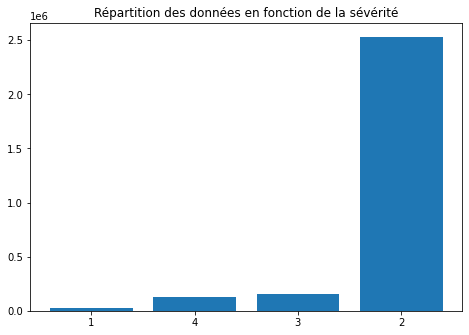

In [ ]:
job_config = bigquery.QueryJobConfig(
    # Run at batch priority, which won't count toward concurrent rate limit.
    priority=bigquery.QueryPriority.BATCH
)

sql = "SELECT Severity, COUNT(ID) AS nombre_occurences FROM tables_projet_labat.US_accidents GROUP BY Severity ORDER BY nombre_occurences"

# Start the query, passing in the extra configuration.
query_job = client.query(sql, job_config=job_config)  # Make an API request.

while(query_job.state != "DONE"):
  # Check on the progress by getting the job's updated state. Once the state
  # is `DONE`, the results are ready.
  query_job = client.get_job(
      query_job.job_id, location=query_job.location
  )  # Make an API request.

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
intitules = []
donnees = []
for row in query_job:
    # Row values can be accessed by field name or index.
    chaine = ""
    # Parcours des colonnes de chaque row
    for i in range(len(row)):
      chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
    print(chaine)
    intitules.append(str(row[0]))
    donnees.append(row[1])
ax.set_title('Répartition des données en fonction de la sévérité')
ax.bar(intitules,donnees)
plt.show()



## Accidents par état

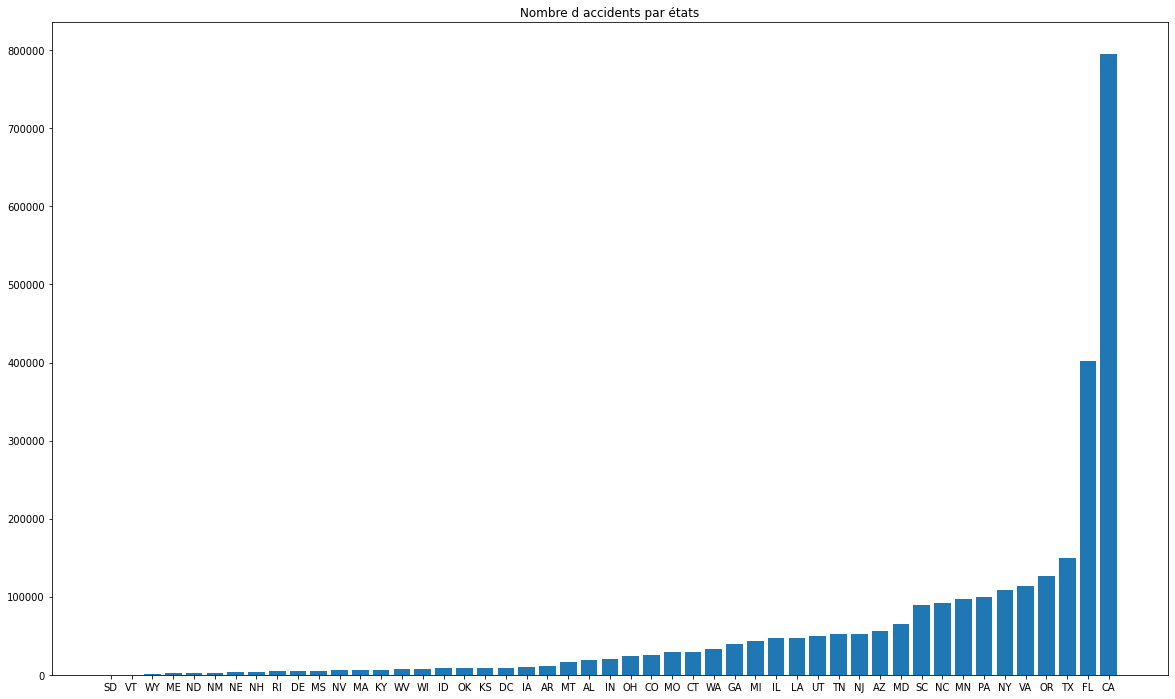

In [ ]:
job_config = bigquery.QueryJobConfig(
    # Run at batch priority, which won't count toward concurrent rate limit.
    priority=bigquery.QueryPriority.BATCH
)

sql = "SELECT State, COUNT(ID) AS nombre_occurences FROM tables_projet_labat.US_accidents GROUP BY State ORDER BY nombre_occurences"

# Start the query, passing in the extra configuration.
query_job = client.query(sql, job_config=job_config)  # Make an API request.

while(query_job.state != "DONE"):
  # Check on the progress by getting the job's updated state. Once the state
  # is `DONE`, the results are ready.
  query_job = client.get_job(
      query_job.job_id, location=query_job.location
  )  # Make an API request.


intitules = []
donnees = []
for row in query_job:
    # Row values can be accessed by field name or index.
    chaine = ""
    # Parcours des colonnes de chaque row
    for i in range(len(row)):
      chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
    intitules.append(str(row[0]))
    donnees.append(row[1])
fig,ax = plt.subplots(figsize=(20,12))
ax.set_title('Nombre d accidents par états')
ax.bar(intitules,donnees)
plt.show()

## Détermination du minimum et du maximum de la distance de l'accident

In [ ]:
job_config = bigquery.QueryJobConfig(
    # Run at batch priority, which won't count toward concurrent rate limit.
    priority=bigquery.QueryPriority.BATCH
)

sql = "SELECT MIN(Distance_km_) AS min_distance, MAX(Distance_km_) AS max_distance, FROM tables_projet_labat.US_accidents"

# Start the query, passing in the extra configuration.
query_job = client.query(sql, job_config=job_config)  # Make an API request.

while(query_job.state != "DONE"):
  # Check on the progress by getting the job's updated state. Once the state
  # is `DONE`, the results are ready.
  query_job = client.get_job(
      query_job.job_id, location=query_job.location
  )  # Make an API request.

for row in query_job:
    # Row values can be accessed by field name or index.
    chaine = ""
    # Parcours des colonnes de chaque row
    for i in range(len(row)):
      chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
    print(chaine)

min_distance : 0.0 ; max_distance : 249.74765798400003 ; 


In [ ]:
job_config = bigquery.QueryJobConfig(
    # Run at batch priority, which won't count toward concurrent rate limit.
    priority=bigquery.QueryPriority.BATCH
)

sql = "SELECT COUNT(ID) AS nombre_moins_un_km FROM tables_projet_labat.US_accidents WHERE Distance_km_ < 1"

# Start the query, passing in the extra configuration.
query_job = client.query(sql, job_config=job_config)  # Make an API request.

while(query_job.state != "DONE"):
  # Check on the progress by getting the job's updated state. Once the state
  # is `DONE`, the results are ready.
  query_job = client.get_job(
      query_job.job_id, location=query_job.location
  )  # Make an API request.

for row in query_job:
    # Row values can be accessed by field name or index.
    chaine = ""
    # Parcours des colonnes de chaque row
    for i in range(len(row)):
      chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
    print(chaine)

nombre_moins_un_km : 2003262 ; 


In [ ]:
job_config = bigquery.QueryJobConfig(
    # Run at batch priority, which won't count toward concurrent rate limit.
    priority=bigquery.QueryPriority.BATCH
)

sql = "SELECT COUNT(ID) AS nombre_plus_un_km FROM tables_projet_labat.US_accidents WHERE Distance_km_ >= 1"

# Start the query, passing in the extra configuration.
query_job = client.query(sql, job_config=job_config)  # Make an API request.

while(query_job.state != "DONE"):
  # Check on the progress by getting the job's updated state. Once the state
  # is `DONE`, the results are ready.
  query_job = client.get_job(
      query_job.job_id, location=query_job.location
  )  # Make an API request.

for row in query_job:
    # Row values can be accessed by field name or index.
    chaine = ""
    # Parcours des colonnes de chaque row
    for i in range(len(row)):
      chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
    print(chaine)

nombre_plus_un_km : 842080 ; 


Plus de 2M de données ont impacté moins d'1 km, quand 800k accidents ont impacté plus d'un km.

## Perturbateurs de conduite liés à la route [PCR]

In [ ]:
marqueurs = ["Bump", "Crossing", "Give_Way", "Junction", "No_Exit", "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming", "Traffic_Signal", "Turning_Loop"]
for marqueur in marqueurs:
  job_config = bigquery.QueryJobConfig(
      # Run at batch priority, which won't count toward concurrent rate limit.
      priority=bigquery.QueryPriority.BATCH
  )

  sql = "SELECT COUNT(ID) AS nombre_" + marqueur + " FROM tables_projet_labat.US_accidents WHERE " + marqueur + "= True"

  # Start the query, passing in the extra configuration.
  query_job = client.query(sql, job_config=job_config)  # Make an API request.

  while(query_job.state != "DONE"):
    # Check on the progress by getting the job's updated state. Once the state
    # is `DONE`, the results are ready.
    query_job = client.get_job(
        query_job.job_id, location=query_job.location
    )  # Make an API request.


  for row in query_job:
      # Row values can be accessed by field name or index.
      chaine = ""
      # Parcours des colonnes de chaque row
      for i in range(len(row)):
        chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
      print(chaine)

nombre_Bump : 1021 ; 
nombre_Crossing : 200212 ; 
nombre_Give_Way : 6868 ; 
nombre_Junction : 290505 ; 
nombre_No_Exit : 4294 ; 
nombre_Railway : 22631 ; 
nombre_Roundabout : 123 ; 
nombre_Station : 67995 ; 
nombre_Stop : 50400 ; 
nombre_Traffic_Calming : 1712 ; 
nombre_Traffic_Signal : 265263 ; 
nombre_Turning_Loop : 0 ; 


On voit que la plupart des accidents avec un PCR à proximité sont liés à la présence d'un carrefour.

On va maintenant déterminer la proportion des accidents avec un PCR à proximité. 

In [ ]:
marqueurs = ["Bump", "Crossing", "Give_Way", "Junction", "No_Exit", "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming", "Traffic_Signal", "Turning_Loop"]
chaine = ""
cpt = 0
for marqueur in marqueurs:
  if (cpt > 0):
    chaine += " OR "
  chaine += marqueur + ' = True'
  cpt += 1


job_config = bigquery.QueryJobConfig(
    # Run at batch priority, which won't count toward concurrent rate limit.
    priority=bigquery.QueryPriority.BATCH
)

sql = "SELECT COUNT(ID) AS nombre_accidents_pcr FROM tables_projet_labat.US_accidents WHERE " + chaine

# Start the query, passing in the extra configuration.
query_job = client.query(sql, job_config=job_config)  # Make an API request.

while(query_job.state != "DONE"):
  # Check on the progress by getting the job's updated state. Once the state
  # is `DONE`, the results are ready.
  query_job = client.get_job(
      query_job.job_id, location=query_job.location
  )  # Make an API request.

for row in query_job:
    # Row values can be accessed by field name or index.
    chaine = ""
    # Parcours des colonnes de chaque row
    for i in range(len(row)):
      chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
    print(chaine)

nombre_accidents_pcr : 723942 ; 


723942 accidents ont eu lieu avec au moins un PCR à proximité (contre 911024 estimé en Pandas).

In [ ]:
pourcentage_pcr = 723942/nombre_de_donnees*100
print("Cela correspond à", pourcentage_pcr, "% des données totales")

Cela correspond à 25.44305746022798 % des données totales


## Perturbateurs de conduite liés aux conditions climatiques [PCC]

### Visibilité

In [ ]:
job_config = bigquery.QueryJobConfig(
    # Run at batch priority, which won't count toward concurrent rate limit.
    priority=bigquery.QueryPriority.BATCH
)

sql = "SELECT MIN(Visibility_km_) AS min_visibility, MAX(Visibility_km_) AS max_visibility, FROM tables_projet_labat.US_accidents"

# Start the query, passing in the extra configuration.
query_job = client.query(sql, job_config=job_config)  # Make an API request.

while(query_job.state != "DONE"):
  # Check on the progress by getting the job's updated state. Once the state
  # is `DONE`, the results are ready.
  query_job = client.get_job(
      query_job.job_id, location=query_job.location
  )  # Make an API request.

min = 0
max = 0
for row in query_job:
    # Row values can be accessed by field name or index.
    chaine = ""
    # Parcours des colonnes de chaque row
    for i in range(len(row)):
      if (i==0):
        min = row[i]
      else :
        max = row[i]
      chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
    print(chaine)

min_visibility : 0.0 ; max_visibility : 225.30816000000002 ; 


In [ ]:
def repartition_donnees_visibilite(data, min, max):
  nombre_partitions = 10
  facteur_additif = round((min + max) / nombre_partitions, 2)
  pas_fini = True
  borne_min = min
  borne_max = borne_min
  legende = []
  valeurs = []
  while pas_fini:
    borne_max += facteur_additif

    job_config = bigquery.QueryJobConfig(
        # Run at batch priority, which won't count toward concurrent rate limit.
        priority=bigquery.QueryPriority.BATCH
    )

    borne_min_requete = str(borne_min).replace('.', '_')
    borne_max_requete = str(borne_max).replace('.', '_')
    sql = "SELECT COUNT(ID) AS visibility_entre_" + str(borne_min_requete) + "_et_"+ str(borne_max_requete) + " FROM tables_projet_labat.US_accidents WHERE Visibility_km_ < " + str(borne_max) + " AND Visibility_km_ >= " + str(borne_min)

    # Start the query, passing in the extra configuration.
    query_job = client.query(sql, job_config=job_config)  # Make an API request.

    while(query_job.state != "DONE"):
      # Check on the progress by getting the job's updated state. Once the state
      # is `DONE`, the results are ready.
      query_job = client.get_job(
          query_job.job_id, location=query_job.location
      )  # Make an API request.

    for row in query_job:
        # Row values can be accessed by field name or index.
        chaine = ""
        # Parcours des colonnes de chaque row
        for i in range(len(row)):
          chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
        print(chaine)
    borne_min += facteur_additif
    pas_fini = borne_max <= max
    print()

In [ ]:
repartition_donnees_visibilite(dataframe_spark, min, max)

visibility_entre_0_0_et_22_53 : 2766933 ; 

visibility_entre_22_53_et_45_06 : 4292 ; 

visibility_entre_45_06_et_67_59 : 2171 ; 

visibility_entre_67_59_et_90_12 : 943 ; 

visibility_entre_90_12_et_112_65 : 84 ; 

visibility_entre_112_65_et_135_18 : 318 ; 

visibility_entre_135_18_et_157_71 : 9 ; 

visibility_entre_157_71_et_180_24 : 39 ; 

visibility_entre_180_24_et_202_77 : 4 ; 

visibility_entre_202_77_et_225_3 : 1 ; 

visibility_entre_225_3_et_247_83 : 2 ; 



La visibilité n'est vraiment pas bien répartie.

In [ ]:
job_config = bigquery.QueryJobConfig(
    # Run at batch priority, which won't count toward concurrent rate limit.
    priority=bigquery.QueryPriority.BATCH
)

sql = "SELECT COUNT(ID) AS visibility_inferieure_15 FROM tables_projet_labat.US_accidents WHERE Visibility_km_ < 15"

# Start the query, passing in the extra configuration.
query_job = client.query(sql, job_config=job_config)  # Make an API request.

while(query_job.state != "DONE"):
  # Check on the progress by getting the job's updated state. Once the state
  # is `DONE`, the results are ready.
  query_job = client.get_job(
      query_job.job_id, location=query_job.location
  )  # Make an API request.

for row in query_job:
    # Row values can be accessed by field name or index.
    chaine = ""
    # Parcours des colonnes de chaque row
    for i in range(len(row)):
      chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
    print(chaine)

visibility_inferieure_15 : 533368 ; 


In [ ]:
job_config = bigquery.QueryJobConfig(
    # Run at batch priority, which won't count toward concurrent rate limit.
    priority=bigquery.QueryPriority.BATCH
)

sql = "SELECT COUNT(ID) AS visibility_superieure_15 FROM tables_projet_labat.US_accidents WHERE Visibility_km_ >= 15"

# Start the query, passing in the extra configuration.
query_job = client.query(sql, job_config=job_config)  # Make an API request.

while(query_job.state != "DONE"):
  # Check on the progress by getting the job's updated state. Once the state
  # is `DONE`, the results are ready.
  query_job = client.get_job(
      query_job.job_id, location=query_job.location
  )  # Make an API request.

for row in query_job:
    # Row values can be accessed by field name or index.
    chaine = ""
    # Parcours des colonnes de chaque row
    for i in range(len(row)):
      chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
    print(chaine)

visibility_superieure_15 : 2241428 ; 


In [ ]:
job_config = bigquery.QueryJobConfig(
    # Run at batch priority, which won't count toward concurrent rate limit.
    priority=bigquery.QueryPriority.BATCH
)

sql = "SELECT COUNT(ID) AS visibility_entre_15_et_20 FROM tables_projet_labat.US_accidents WHERE Visibility_km_ >= 15 AND Visibility_km_ < 20"

# Start the query, passing in the extra configuration.
query_job = client.query(sql, job_config=job_config)  # Make an API request.

while(query_job.state != "DONE"):
  # Check on the progress by getting the job's updated state. Once the state
  # is `DONE`, the results are ready.
  query_job = client.get_job(
      query_job.job_id, location=query_job.location
  )  # Make an API request.

for row in query_job:
    # Row values can be accessed by field name or index.
    chaine = ""
    # Parcours des colonnes de chaque row
    for i in range(len(row)):
      chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
    print(chaine)

visibility_entre_15_et_20 : 2230449 ; 


2.2M d'accidents, donc la grande majorité des accidents, ont eu lieu avec une visibilité entre 15 et 20 km.

### Vitesse du vent

In [ ]:
job_config = bigquery.QueryJobConfig(
    # Run at batch priority, which won't count toward concurrent rate limit.
    priority=bigquery.QueryPriority.BATCH
)

sql = "SELECT MIN(Wind_Speed_kmh_) AS min_vitesse_vent, MAX(Wind_Speed_kmh_) AS max_vitesse_vent FROM tables_projet_labat.US_accidents"

# Start the query, passing in the extra configuration.
query_job = client.query(sql, job_config=job_config)  # Make an API request.

while(query_job.state != "DONE"):
  # Check on the progress by getting the job's updated state. Once the state
  # is `DONE`, the results are ready.
  query_job = client.get_job(
      query_job.job_id, location=query_job.location
  )  # Make an API request.

for row in query_job:
    # Row values can be accessed by field name or index.
    chaine = ""
    # Parcours des colonnes de chaque row
    for i in range(len(row)):
      chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
    print(chaine)

min_vitesse_vent : 0.0 ; max_vitesse_vent : 1749.3569280000002 ; 


La vitesse du vent lors d'un accident varie entre 0 et 1749km/h. On voit ici qu'il y a un problème sur les données, car le vent ne peut pas aller aussi vite. Il est noté [ici](https://www.meteo-paris.com/actualites/meteo-extreme-quels-sont-les-records-climatiques-dans-le-monde) que le maximum de la vitesse du vent enregistrée est de 408km/h.

In [ ]:
job_config = bigquery.QueryJobConfig(
    # Run at batch priority, which won't count toward concurrent rate limit.
    priority=bigquery.QueryPriority.BATCH
)

sql = "SELECT COUNT(ID) AS nombre_donnees_superieurs_408 FROM tables_projet_labat.US_accidents WHERE Wind_Speed_kmh_ > 408"

# Start the query, passing in the extra configuration.
query_job = client.query(sql, job_config=job_config)  # Make an API request.

while(query_job.state != "DONE"):
  # Check on the progress by getting the job's updated state. Once the state
  # is `DONE`, the results are ready.
  query_job = client.get_job(
      query_job.job_id, location=query_job.location
  )  # Make an API request.

for row in query_job:
    # Row values can be accessed by field name or index.
    chaine = ""
    # Parcours des colonnes de chaque row
    for i in range(len(row)):
      chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
    print(chaine)

nombre_donnees_superieurs_408 : 8 ; 


Il y a 8 données supérieures à cette donnée, donc on sait que ces valeurs ne sont pas justes. On suppose que c'est un problème d'écriture de virgule et que ces données valent plus de 100km.

En se servant des données se trouvant [ici](https://vigilance.meteofrance.fr/fr/dangers-meteorologiques-vent-violent), on regardera les données où le vent est supérieur à 90km/h (moyenne entre 80 et 100km/h).

In [ ]:
job_config = bigquery.QueryJobConfig(
    # Run at batch priority, which won't count toward concurrent rate limit.
    priority=bigquery.QueryPriority.BATCH
)

sql = "SELECT COUNT(ID) AS nombre_donnees_inferieures_90 FROM tables_projet_labat.US_accidents WHERE Wind_Speed_kmh_ < 90"

# Start the query, passing in the extra configuration.
query_job = client.query(sql, job_config=job_config)  # Make an API request.

while(query_job.state != "DONE"):
  # Check on the progress by getting the job's updated state. Once the state
  # is `DONE`, the results are ready.
  query_job = client.get_job(
      query_job.job_id, location=query_job.location
  )  # Make an API request.

for row in query_job:
    # Row values can be accessed by field name or index.
    chaine = ""
    # Parcours des colonnes de chaque row
    for i in range(len(row)):
      chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
    print(chaine)

nombre_donnees_inferieures_90 : 2687291 ; 


In [ ]:
job_config = bigquery.QueryJobConfig(
    # Run at batch priority, which won't count toward concurrent rate limit.
    priority=bigquery.QueryPriority.BATCH
)

sql = "SELECT COUNT(ID) AS nombre_donnees_superieures_90 FROM tables_projet_labat.US_accidents WHERE Wind_Speed_kmh_ >= 90"

# Start the query, passing in the extra configuration.
query_job = client.query(sql, job_config=job_config)  # Make an API request.

while(query_job.state != "DONE"):
  # Check on the progress by getting the job's updated state. Once the state
  # is `DONE`, the results are ready.
  query_job = client.get_job(
      query_job.job_id, location=query_job.location
  )  # Make an API request.

for row in query_job:
    # Row values can be accessed by field name or index.
    chaine = ""
    # Parcours des colonnes de chaque row
    for i in range(len(row)):
      chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
    print(chaine)

nombre_donnees_superieures_90 : 107 ; 


In [ ]:
job_config = bigquery.QueryJobConfig(
    # Run at batch priority, which won't count toward concurrent rate limit.
    priority=bigquery.QueryPriority.BATCH
)

sql = "SELECT COUNT(ID) AS nombre_donnees_inferieures_50 FROM tables_projet_labat.US_accidents WHERE Wind_Speed_kmh_ < 50"

# Start the query, passing in the extra configuration.
query_job = client.query(sql, job_config=job_config)  # Make an API request.

while(query_job.state != "DONE"):
  # Check on the progress by getting the job's updated state. Once the state
  # is `DONE`, the results are ready.
  query_job = client.get_job(
      query_job.job_id, location=query_job.location
  )  # Make an API request.

for row in query_job:
    # Row values can be accessed by field name or index.
    chaine = ""
    # Parcours des colonnes de chaque row
    for i in range(len(row)):
      chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
    print(chaine)

nombre_donnees_inferieures_50 : 2684531 ; 


In [ ]:
job_config = bigquery.QueryJobConfig(
    # Run at batch priority, which won't count toward concurrent rate limit.
    priority=bigquery.QueryPriority.BATCH
)

sql = "SELECT COUNT(ID) AS nombre_donnees_superieures_50 FROM tables_projet_labat.US_accidents WHERE Wind_Speed_kmh_ >= 50"

# Start the query, passing in the extra configuration.
query_job = client.query(sql, job_config=job_config)  # Make an API request.

while(query_job.state != "DONE"):
  # Check on the progress by getting the job's updated state. Once the state
  # is `DONE`, the results are ready.
  query_job = client.get_job(
      query_job.job_id, location=query_job.location
  )  # Make an API request.

for row in query_job:
    # Row values can be accessed by field name or index.
    chaine = ""
    # Parcours des colonnes de chaque row
    for i in range(len(row)):
      chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
    print(chaine)

nombre_donnees_superieures_50 : 2867 ; 


In [ ]:
job_config = bigquery.QueryJobConfig(
    # Run at batch priority, which won't count toward concurrent rate limit.
    priority=bigquery.QueryPriority.BATCH
)

sql = "SELECT COUNT(ID) AS nombre_donnees_inferieures_20 FROM tables_projet_labat.US_accidents WHERE Wind_Speed_kmh_ < 20"

# Start the query, passing in the extra configuration.
query_job = client.query(sql, job_config=job_config)  # Make an API request.

while(query_job.state != "DONE"):
  # Check on the progress by getting the job's updated state. Once the state
  # is `DONE`, the results are ready.
  query_job = client.get_job(
      query_job.job_id, location=query_job.location
  )  # Make an API request.

for row in query_job:
    # Row values can be accessed by field name or index.
    chaine = ""
    # Parcours des colonnes de chaque row
    for i in range(len(row)):
      chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
    print(chaine)

nombre_donnees_inferieures_20 : 2231706 ; 


In [ ]:
job_config = bigquery.QueryJobConfig(
    # Run at batch priority, which won't count toward concurrent rate limit.
    priority=bigquery.QueryPriority.BATCH
)

sql = "SELECT COUNT(ID) AS nombre_donnees_superieures_20 FROM tables_projet_labat.US_accidents WHERE Wind_Speed_kmh_ >= 20"

# Start the query, passing in the extra configuration.
query_job = client.query(sql, job_config=job_config)  # Make an API request.

while(query_job.state != "DONE"):
  # Check on the progress by getting the job's updated state. Once the state
  # is `DONE`, the results are ready.
  query_job = client.get_job(
      query_job.job_id, location=query_job.location
  )  # Make an API request.

for row in query_job:
    # Row values can be accessed by field name or index.
    chaine = ""
    # Parcours des colonnes de chaque row
    for i in range(len(row)):
      chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
    print(chaine)

nombre_donnees_superieures_20 : 455692 ; 


Il y a beaucoup plus de données d'accidents où le vent souffle à moins de 20 km/h (environ 5 fois plus) qu'avec un vent de plus de 20km/h.

### Précipitations

In [ ]:
job_config = bigquery.QueryJobConfig(
    # Run at batch priority, which won't count toward concurrent rate limit.
    priority=bigquery.QueryPriority.BATCH
)

sql = "SELECT MIN(Precipitation_mm_) AS min_precipitations, MAX(Precipitation_mm_) AS max_precipitations FROM tables_projet_labat.US_accidents"

# Start the query, passing in the extra configuration.
query_job = client.query(sql, job_config=job_config)  # Make an API request.

while(query_job.state != "DONE"):
  # Check on the progress by getting the job's updated state. Once the state
  # is `DONE`, the results are ready.
  query_job = client.get_job(
      query_job.job_id, location=query_job.location
  )  # Make an API request.

for row in query_job:
    # Row values can be accessed by field name or index.
    chaine = ""
    # Parcours des colonnes de chaque row
    for i in range(len(row)):
      chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
    print(chaine)

min_precipitations : 0.0 ; max_precipitations : 588.0 ; 


In [ ]:
tab_where = ["Precipitation_mm_ < 2", 'Precipitation_mm_ >= 2 AND Precipitation_mm_ < 7.6', 'Precipitation_mm_ >= 7.6']
tab_pluie = ['pluie_faible', 'pluie_moderee', 'pluie_forte']
for i in range(len(tab_where)):
  job_config = bigquery.QueryJobConfig(
      # Run at batch priority, which won't count toward concurrent rate limit.
      priority=bigquery.QueryPriority.BATCH
  )

  sql = "SELECT COUNT(ID) AS nombre_" + tab_pluie[i] + " FROM tables_projet_labat.US_accidents WHERE " + tab_where[i]

  # Start the query, passing in the extra configuration.
  query_job = client.query(sql, job_config=job_config)  # Make an API request.

  while(query_job.state != "DONE"):
    # Check on the progress by getting the job's updated state. Once the state
    # is `DONE`, the results are ready.
    query_job = client.get_job(
        query_job.job_id, location=query_job.location
    )  # Make an API request.

  for row in query_job:
      # Row values can be accessed by field name or index.
      chaine = ""
      # Parcours des colonnes de chaque row
      for i in range(len(row)):
        chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
      print(chaine)

nombre_pluie_faible : 2248378 ; 
nombre_pluie_moderee : 39340 ; 
nombre_pluie_forte : 8166 ; 


### Conditions climatiques

Weather_Condition : Light Haze ; nombre_occurences : 1 ; 
Weather_Condition : Light Fog ; nombre_occurences : 1 ; 
Weather_Condition : Sand / Dust Whirlwinds / Windy ; nombre_occurences : 1 ; 
Weather_Condition : Sand / Dust Whirls Nearby ; nombre_occurences : 1 ; 
Weather_Condition : Sleet / Windy ; nombre_occurences : 1 ; 
Weather_Condition : Drifting Snow ; nombre_occurences : 1 ; 
Weather_Condition : Heavy Freezing Rain ; nombre_occurences : 1 ; 
Weather_Condition : Heavy Rain Shower / Windy ; nombre_occurences : 1 ; 
Weather_Condition : Heavy Thunderstorms with Small Hail ; nombre_occurences : 1 ; 
Weather_Condition : Thunder and Hail / Windy ; nombre_occurences : 1 ; 
Weather_Condition : Heavy Blowing Snow ; nombre_occurences : 1 ; 
Weather_Condition : Low Drifting Snow ; nombre_occurences : 1 ; 
Weather_Condition : Mist / Windy ; nombre_occurences : 1 ; 
Weather_Condition : Heavy Rain Showers ; nombre_occurences : 1 ; 
Weather_Condition : Dust Whirls ; nombre_occurences : 1 ; 
W

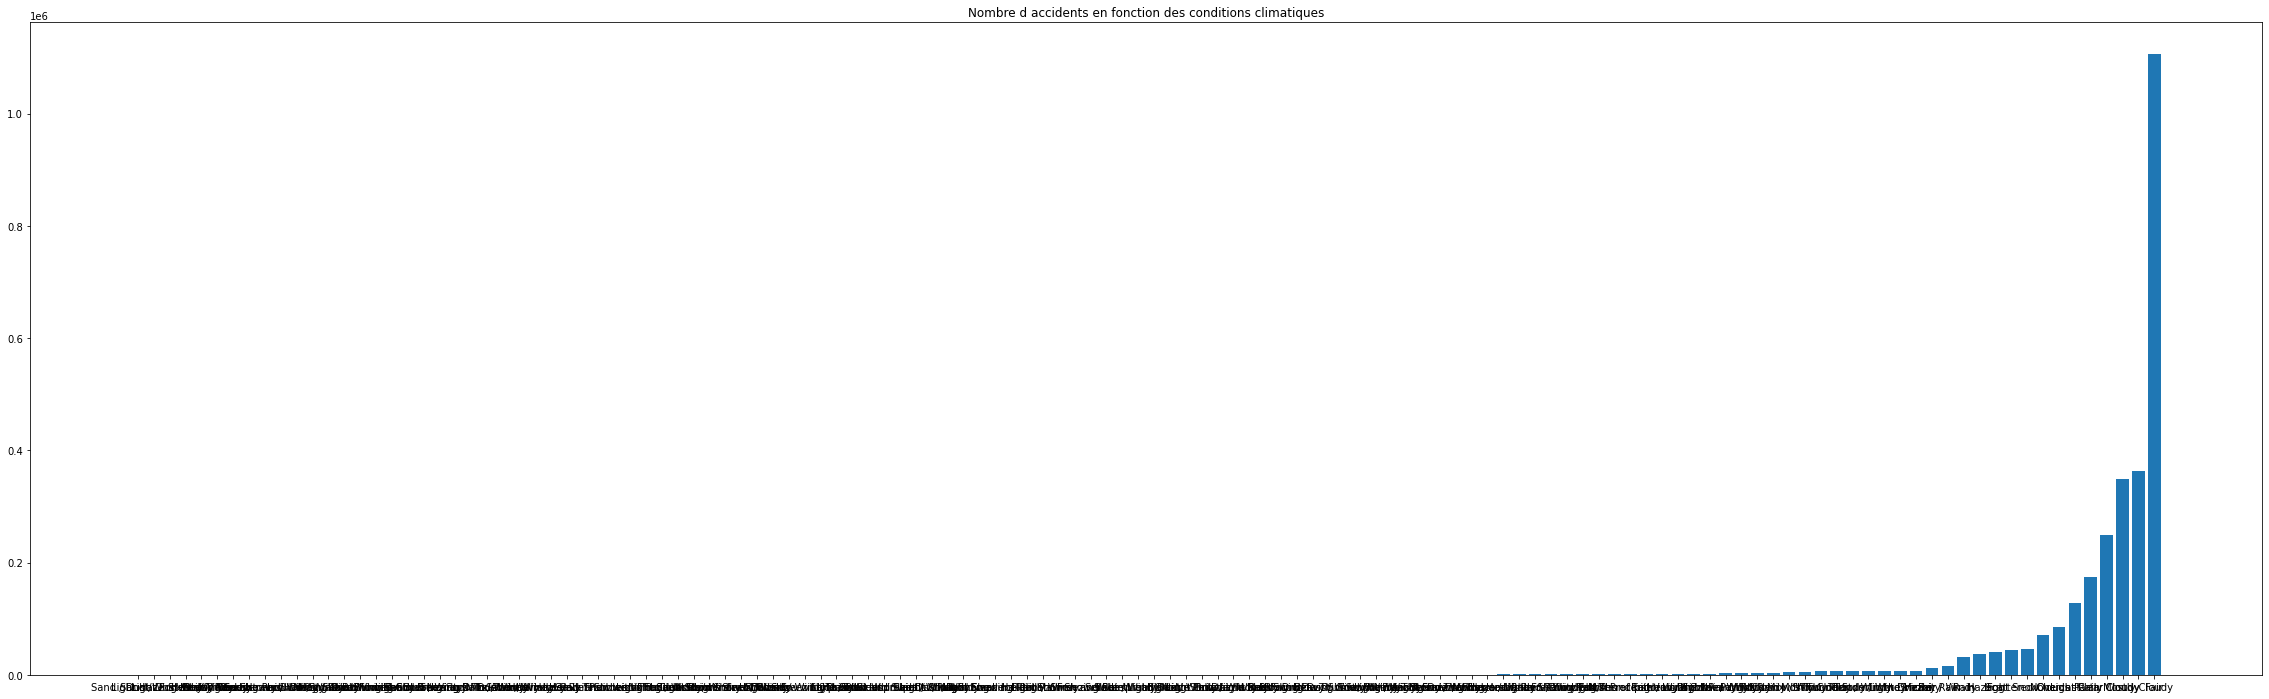

In [ ]:
job_config = bigquery.QueryJobConfig(
    # Run at batch priority, which won't count toward concurrent rate limit.
    priority=bigquery.QueryPriority.BATCH
)

sql = "SELECT Weather_Condition, COUNT(ID) AS nombre_occurences FROM tables_projet_labat.US_accidents GROUP BY Weather_Condition ORDER BY nombre_occurences"

# Start the query, passing in the extra configuration.
query_job = client.query(sql, job_config=job_config)  # Make an API request.

while(query_job.state != "DONE"):
  # Check on the progress by getting the job's updated state. Once the state
  # is `DONE`, the results are ready.
  query_job = client.get_job(
      query_job.job_id, location=query_job.location
  )  # Make an API request.

intitules = []
donnees = []
for row in query_job:
    # Row values can be accessed by field name or index.
    chaine = ""
    # Parcours des colonnes de chaque row
    for i in range(len(row)):
      chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
    print(chaine)   
    intitules.append(str(row[0]))
    donnees.append(row[1])
fig,ax = plt.subplots(figsize=(40,12))
ax.set_title('Nombre d accidents en fonction des conditions climatiques')
ax.bar(intitules,donnees)
plt.show()

La grande majorité des accidents ont lieu avec un temps clair. De plus, la pluie arrive en sizième position, et ce n'est qu'une pluie légère.

### Jour et nuit (basé sur sunrise/sunset)

Sunrise_Sunset : None ; nombre_occurences : 2867 ; 
Sunrise_Sunset : Night ; nombre_occurences : 1030540 ; 
Sunrise_Sunset : Day ; nombre_occurences : 1811935 ; 


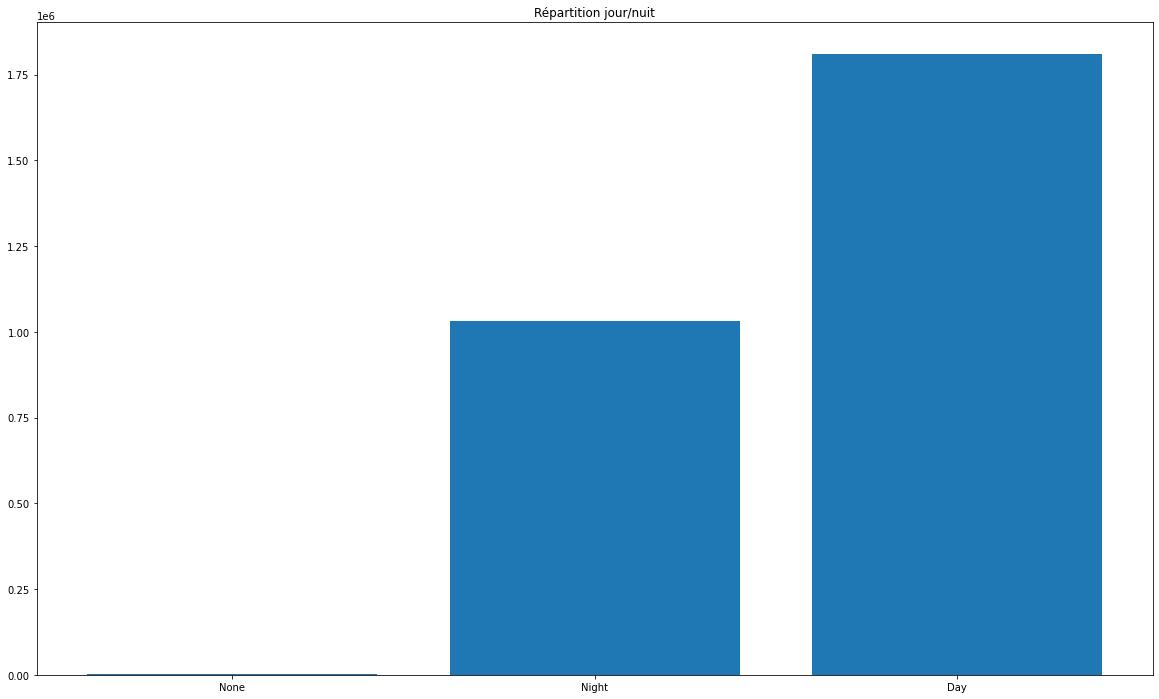

In [ ]:
job_config = bigquery.QueryJobConfig(
    # Run at batch priority, which won't count toward concurrent rate limit.
    priority=bigquery.QueryPriority.BATCH
)

sql = "SELECT Sunrise_Sunset, COUNT(ID) AS nombre_occurences FROM tables_projet_labat.US_accidents GROUP BY Sunrise_Sunset ORDER BY nombre_occurences"

# Start the query, passing in the extra configuration.
query_job = client.query(sql, job_config=job_config)  # Make an API request.

while(query_job.state != "DONE"):
  # Check on the progress by getting the job's updated state. Once the state
  # is `DONE`, the results are ready.
  query_job = client.get_job(
      query_job.job_id, location=query_job.location
  )  # Make an API request.

intitules = []
donnees = []
for row in query_job:
    # Row values can be accessed by field name or index.
    chaine = ""
    # Parcours des colonnes de chaque row
    for i in range(len(row)):
      chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
    print(chaine)
    intitules.append(str(row[0]))
    donnees.append(row[1])
fig,ax = plt.subplots(figsize=(20,12))
ax.set_title('Répartition jour/nuit')
ax.bar(intitules,donnees)
plt.show()

La majorité des accidents se déroulent le jour, même si on n'a pas un écart aussi grand que pour d'autre variables. Il y a cependant 1.8 fois plus d'accidents de jours que de nuit. C'est lié au fait qu'il y a plus de traffic le jour, et donc plus de risques d'accidents.

### Jour et nuit (basé sur le crépuscule civil)

Civil_Twilight : None ; nombre_occurences : 2867 ; 
Civil_Twilight : Night ; nombre_occurences : 913372 ; 
Civil_Twilight : Day ; nombre_occurences : 1929103 ; 


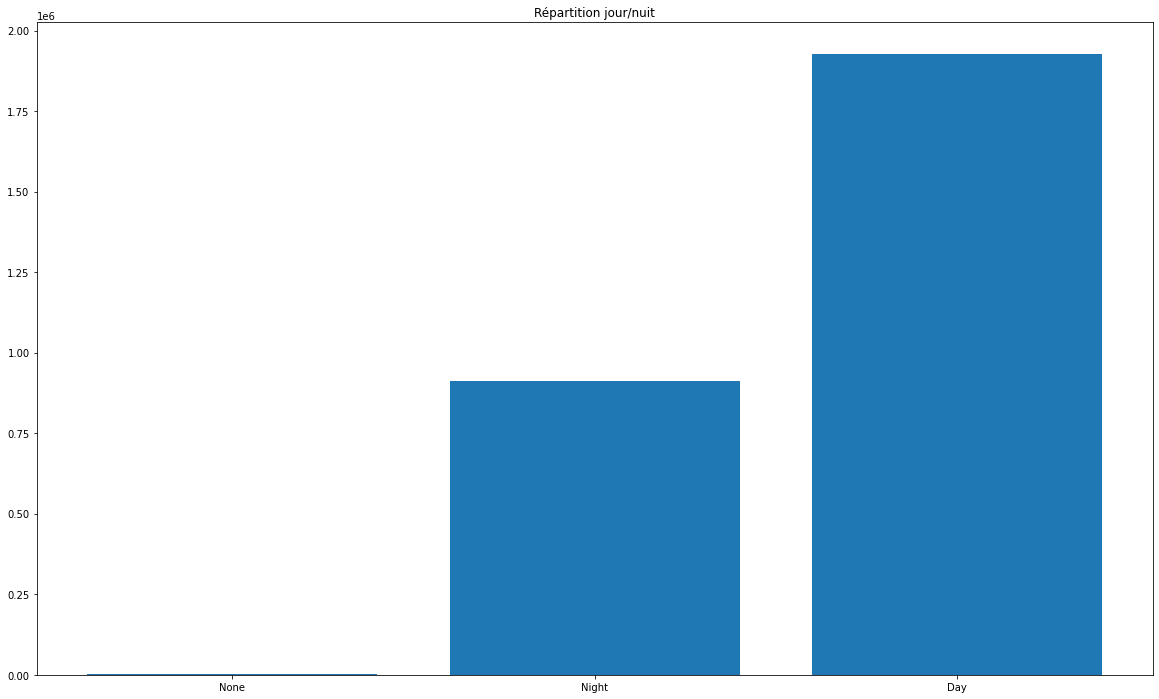

In [ ]:
job_config = bigquery.QueryJobConfig(
    # Run at batch priority, which won't count toward concurrent rate limit.
    priority=bigquery.QueryPriority.BATCH
)

sql = "SELECT Civil_Twilight, COUNT(ID) AS nombre_occurences FROM tables_projet_labat.US_accidents GROUP BY Civil_Twilight ORDER BY nombre_occurences"

# Start the query, passing in the extra configuration.
query_job = client.query(sql, job_config=job_config)  # Make an API request.

while(query_job.state != "DONE"):
  # Check on the progress by getting the job's updated state. Once the state
  # is `DONE`, the results are ready.
  query_job = client.get_job(
      query_job.job_id, location=query_job.location
  )  # Make an API request.

intitules = []
donnees = []
for row in query_job:
    # Row values can be accessed by field name or index.
    chaine = ""
    # Parcours des colonnes de chaque row
    for i in range(len(row)):
      chaine += query_job._query_results._properties['schema']['fields'][i]['name'] + " : " + str(row[i]) + " ; "
    print(chaine)
    intitules.append(str(row[0]))
    donnees.append(row[1])
fig,ax = plt.subplots(figsize=(20,12))
ax.set_title('Répartition jour/nuit')
ax.bar(intitules,donnees)
plt.show()

On remarque un décalage entre les valeurs Jour et Nuit pour ces deux indicateurs. En effet, ils n'utilisent pas la même règle de décision. Cependant, les données sont comparables car les résultats sont proches.